In [31]:
!pip install matplotlib
!pip install NumPy
!pip install tensorflow
!pip install obspy
!pip install scikit-learn

In [204]:
import obspy
import numpy as np
from obspy import read
from obspy.signal.filter import bandpass
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime
import csv


In [205]:
def extract_time_domain_features(trace):
    data = trace.data
    features = {}

    # Time-domain statistical features
    features['mean'] = np.mean(data)
    features['std_dev'] = np.std(data)
    features['min'] = np.min(data)
    features['max'] = np.max(data)
    features['range'] = np.ptp(data)  # Peak-to-peak range
    features['rms'] = np.sqrt(np.mean(data**2))  # Root Mean Square
    features['skewness'] = skew(data)
    features['kurtosis'] = kurtosis(data)

    return features

In [206]:
def extract_frequency_domain_features(trace, sampling_rate):
    data = trace.data

    # Perform Fourier Transform to focus on frequency data
    N = len(data)
    yf = fft(data)
    xf = np.fft.fftfreq(N, 1 / sampling_rate)  # Frequency array

    # Only take the positive half of frequencies
    positive_frequencies = xf[:N//2]
    amplitude_spectrum = np.abs(yf[:N//2])

    # Frequency-domain features
    features = {}
    features['dominant_freq'] = positive_frequencies[np.argmax(amplitude_spectrum)]
    features['spectral_centroid'] = np.sum(positive_frequencies * amplitude_spectrum) / np.sum(amplitude_spectrum)
    features['spectral_bandwidth'] = np.sqrt(np.sum(((positive_frequencies - features['spectral_centroid'])**2) * amplitude_spectrum) / np.sum(amplitude_spectrum))
    features['spectral_energy'] = np.sum(amplitude_spectrum**2)

    return features

In [225]:
def segment_trace(trace, window_size, overlap):
    data = trace.data
    sampling_rate = trace.stats.sampling_rate
    step_size = int(window_size * (1 - overlap) * sampling_rate)
    window_length = int(window_size * sampling_rate)

    segments = []
    for start in range(0, len(data) - window_length, step_size):
        segment = data[start:start + window_length]
        segments.append(segment)

    return segments

In [226]:
def extract_combined_features(trace):
    time_features = extract_time_domain_features(trace)
    frequency_features = extract_frequency_domain_features(trace, trace.stats.sampling_rate)

    # Combine both sets of features into a single dictionary
    combined_features = {**time_features, **frequency_features}
    return combined_features

In [227]:
# Define the autoencoder model
def build_autoencoder(input_dim, encoding_dim):
    # Encoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
    # here we reduce the latent space in attempt to weed out any outliers
    # this configuration yielded the best results
    encoded_1 = layers.Dense(3, activation='relu')(encoded)

    # Decoder
    decoded_1 = layers.Dense(input_dim, activation='sigmoid')(encoded_1)

    # Autoencoder
    autoencoder = models.Model(input_layer, decoded_1)

    # Compile the autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')  # Use Mean Squared Error loss
    return autoencoder

In [228]:
def preprocess_data(input_data: list[str], isTest: bool):
    # Load miniSEED file
    # Replace 'your_file.mseed' with the path to your miniSEED file

    all_segment_features = []

    catalog_file = "/content/apollo12_catalog_GradeA_final.csv"
    catalog_dict = parse_csv_to_dict(catalog_file)

    for record in input_data:
        st = read(record)

        if not isTest:
          start_time = st[0].stats.starttime
          file_name = os.path.basename(record)
          try:
            end_time = UTCDateTime(catalog_dict[file_name])
            # Limit the stream to the specified time range
            limited_stream = st.slice(starttime=start_time, endtime=end_time)
            limited_stream.plot()

            # Select a trace (e.g., the first trace in the stream)
            tr = limited_stream[0]
          except:
            # if the key is not found, the file has no seismic activity, use original stream end time.
            tr = st[0]
        else:
          tr = st[0]

        # Apply a bandpass filter to remove noise outside the target frequency range
        # Adjust frequency range (lowcut, highcut) as needed
        lowcut = 0.5  # Lower frequency bound (Hz)
        highcut = 1.0  # Upper frequency bound (Hz)
        filtered_trace = tr.copy()
        filtered_trace.filter("highpass", freq=lowcut)

        # Segment trace into 5-second windows with 50% overlap
        window_size = 400  # seconds
        overlap = 0.5
        segments = segment_trace(filtered_trace, window_size, overlap)

        # Suppose we have the extracted features from each segment
        # Create a list to store the feature vectors for each segment
        segments_features = []

        # Example loop over all segments to extract combined features
        for segment in segments:
            seg_trace = obspy.Trace(data=segment, header=filtered_trace.stats)
            segment_features = extract_combined_features(seg_trace)
            all_segment_features.append(list(segment_features.values()))

    # Convert the list of feature vectors to a NumPy array

    X = np.array(all_segment_features)

    # Normalize the data to the range [0, 1]
    # try logarithmic transformation
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled

def parse_csv_to_dict(file_path):
    result_dict = {}
    with open(file_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            if len(row) >= 2:  # Ensure there are at least two columns
                key = row[0] + ".mseed"
                value = row[1]
                result_dict[key] = value
    return result_dict


def determine_start_time():
  return


In [229]:
import os

train_path = "/content/training/"
test_path = "/content/test_data/"
# to store files in a list
train_data = []
test_data = []

# dirs=directories
for (root, dirs, file) in os.walk(train_path):
    for f in file:
        if '.mseed' in f:
            train_data.append(train_path + f)

for (root, dirs, file) in os.walk(test_path):
    for f in file:
        if '.mseed' in f:
            test_data.append(test_path + f)

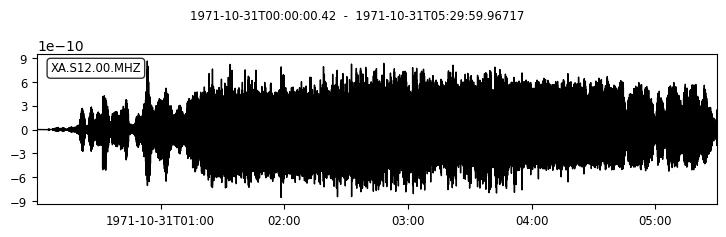

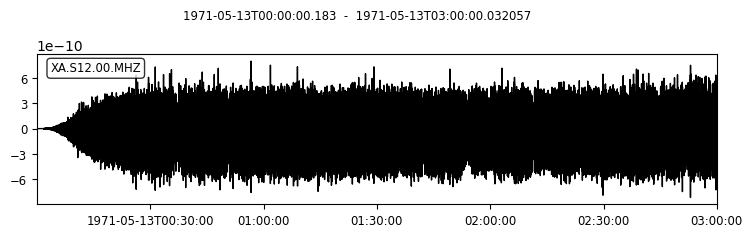

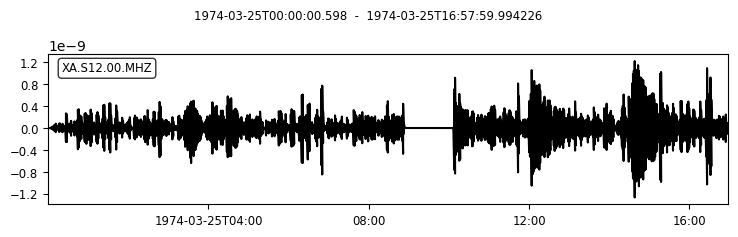

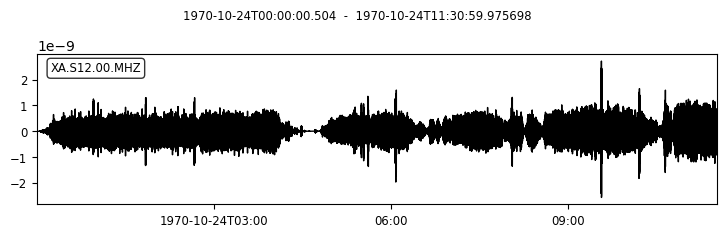

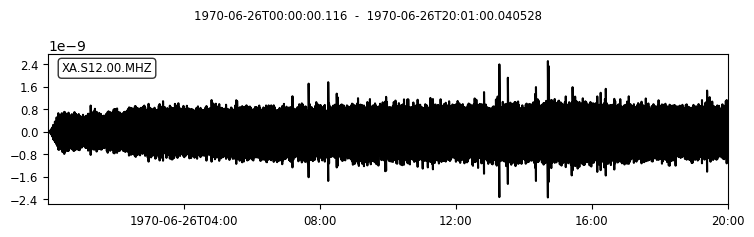

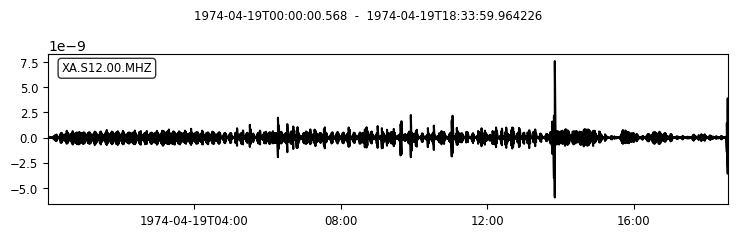

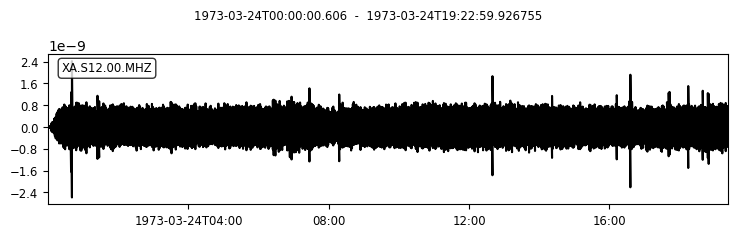

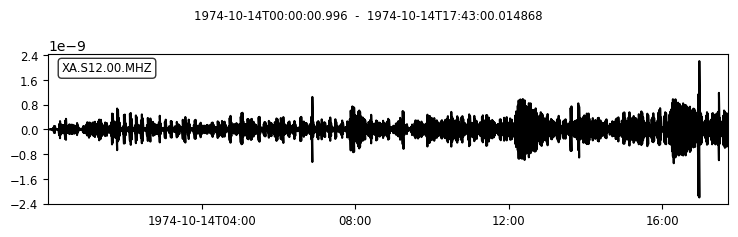

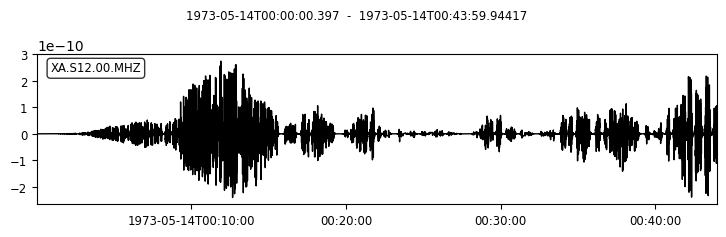

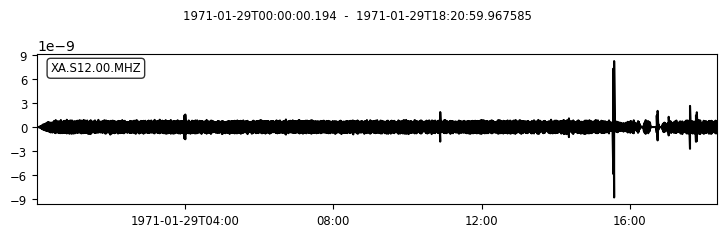

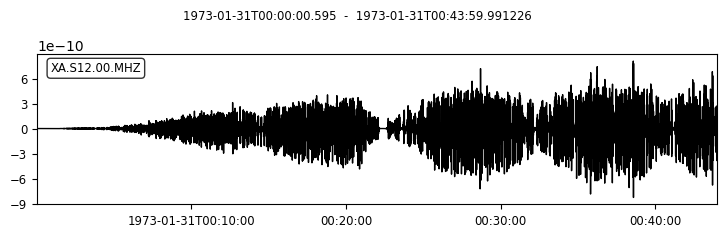

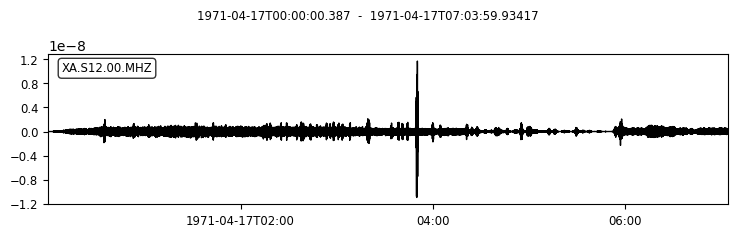

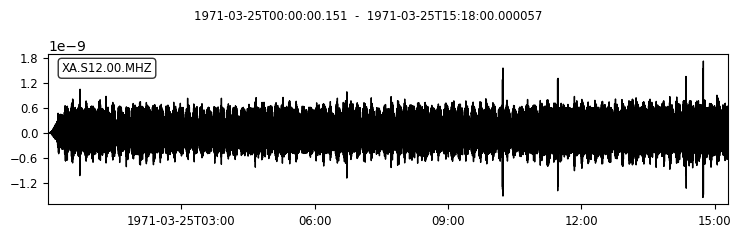

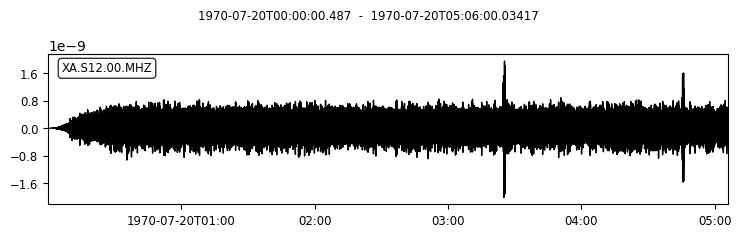

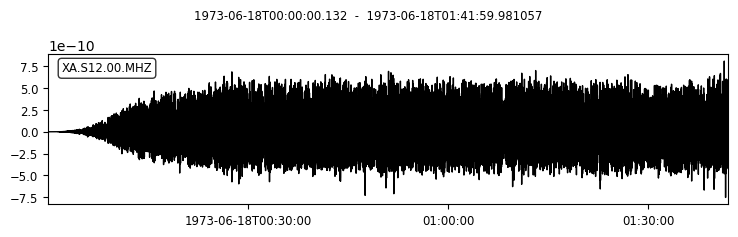

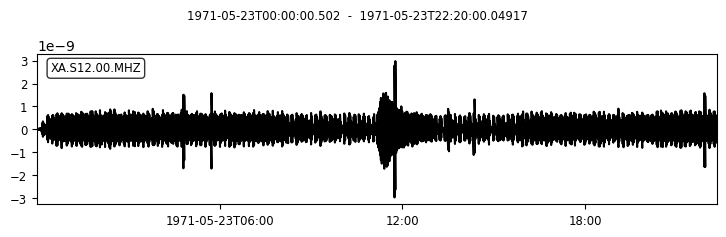

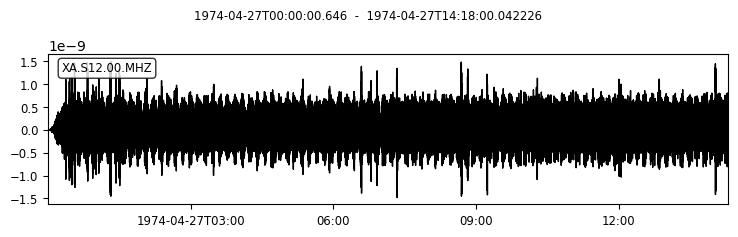

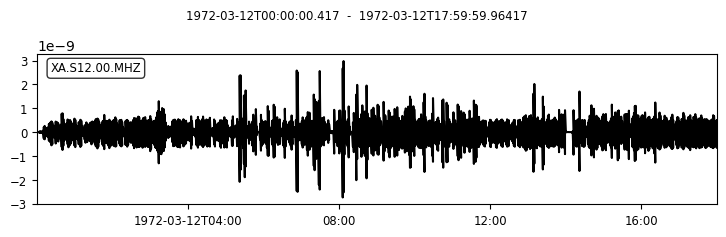

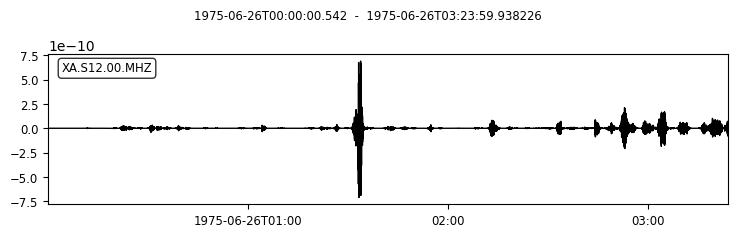

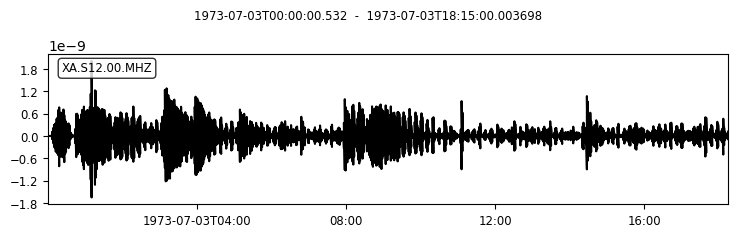

/usr/local/lib/python3.10/dist-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/usr/local/lib/python3.10/dist-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


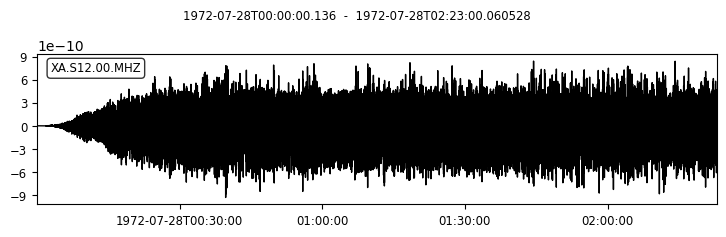

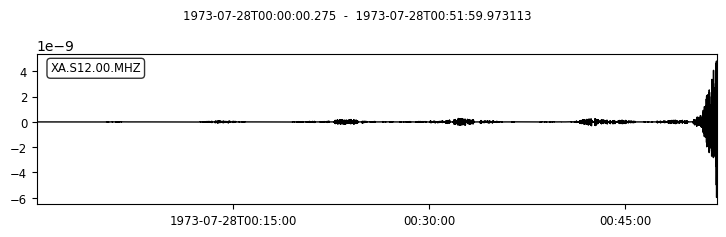

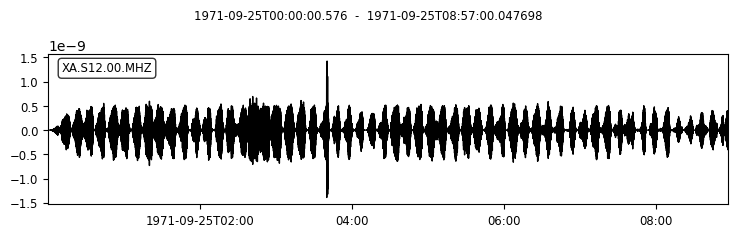

/usr/local/lib/python3.10/dist-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/usr/local/lib/python3.10/dist-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


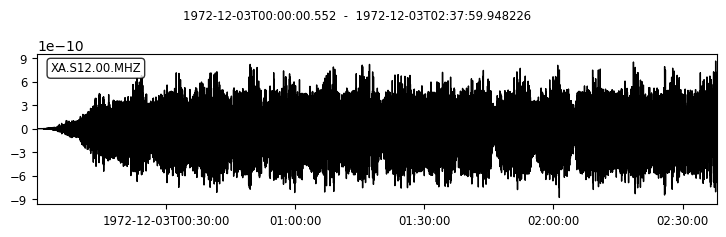

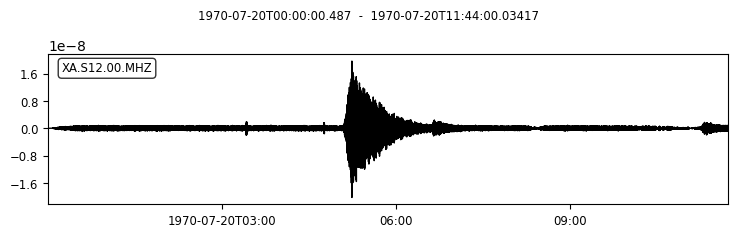

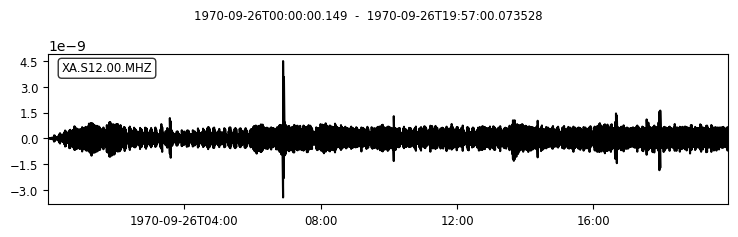

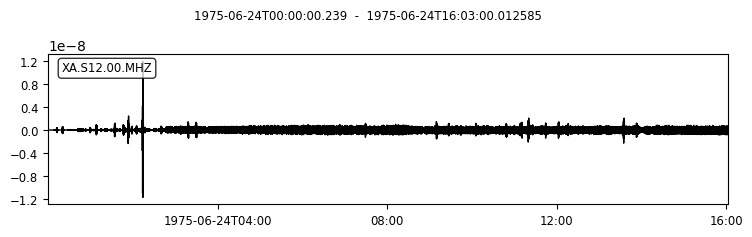

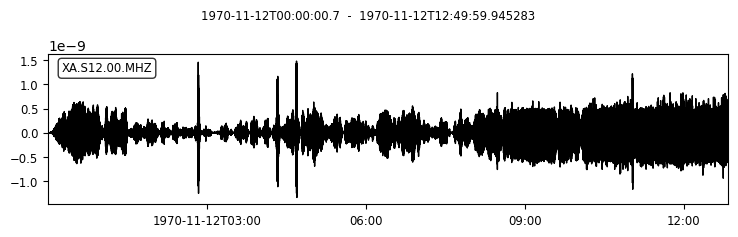

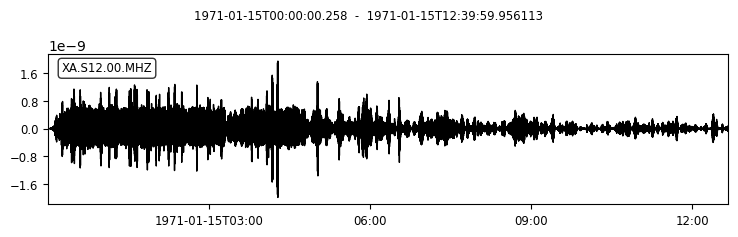

/usr/local/lib/python3.10/dist-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/usr/local/lib/python3.10/dist-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


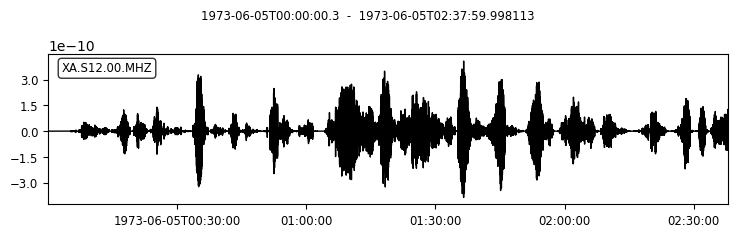

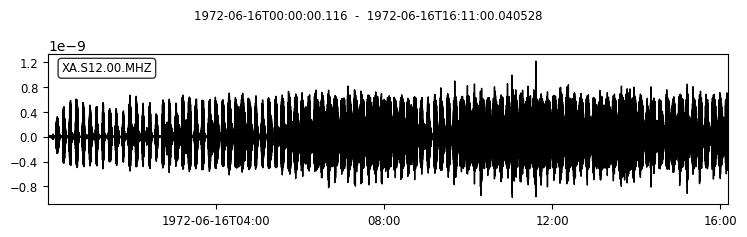

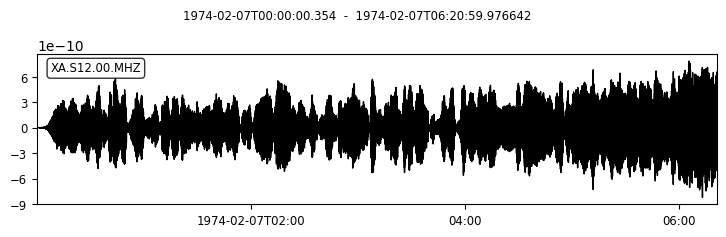

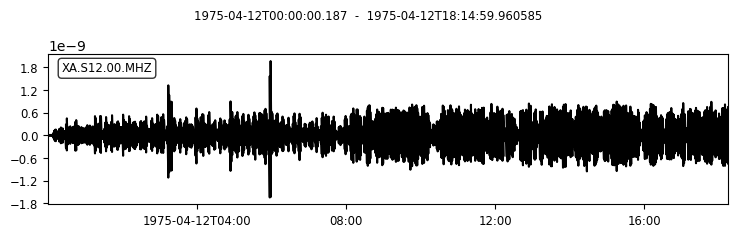

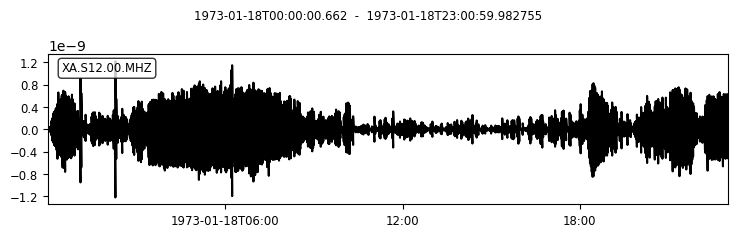

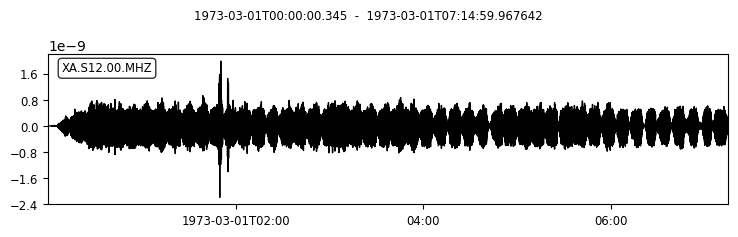

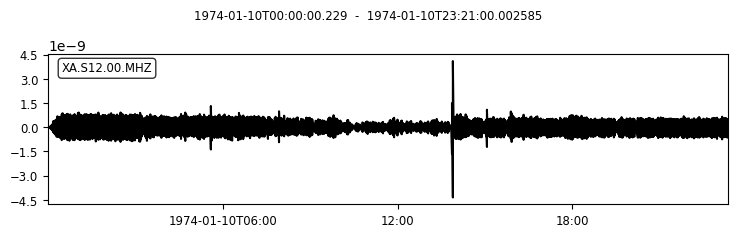

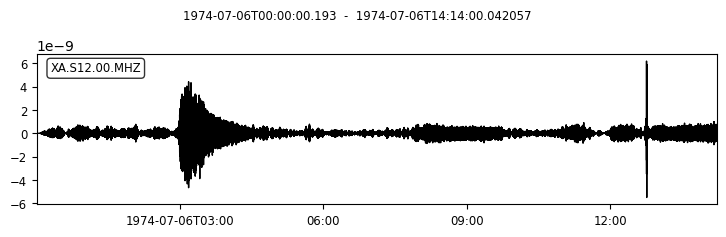

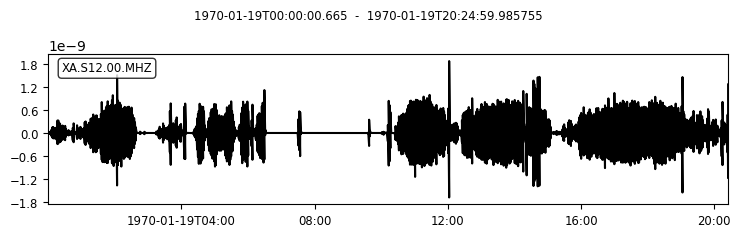

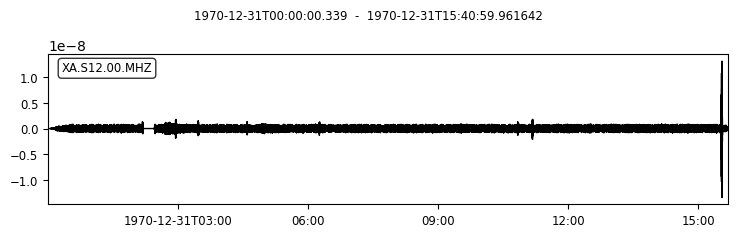

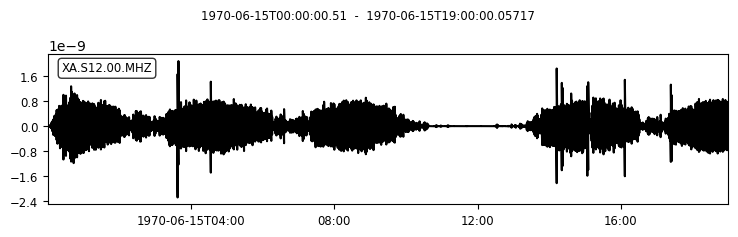

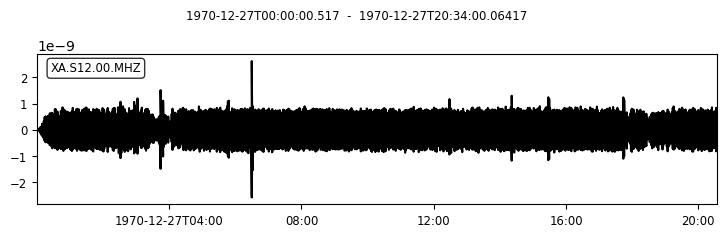

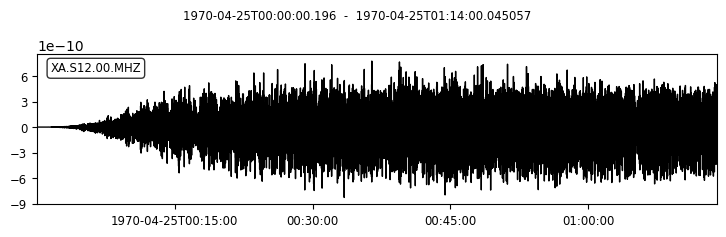

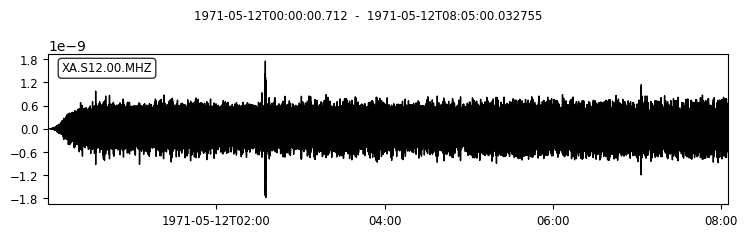

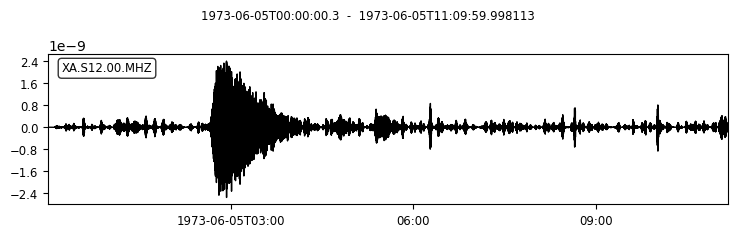

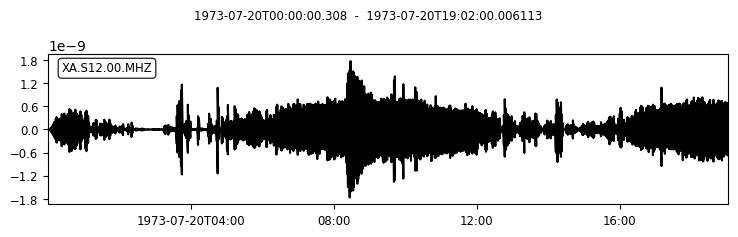

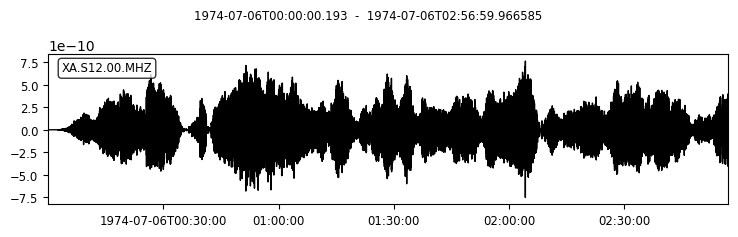

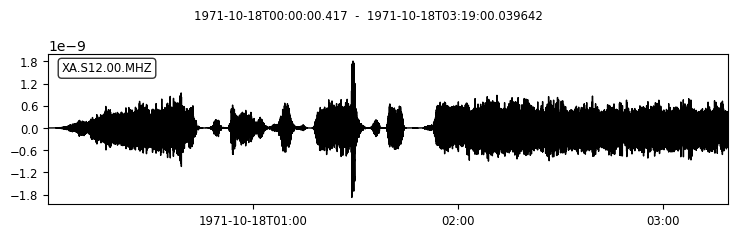

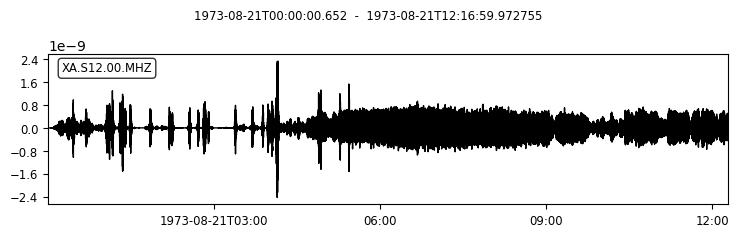

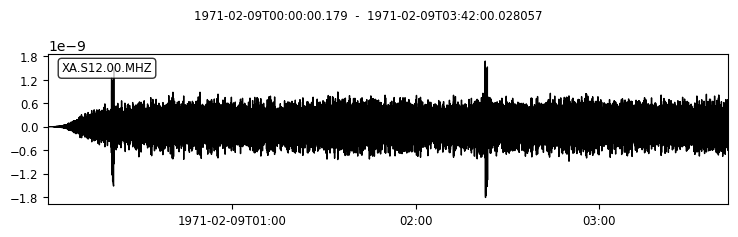

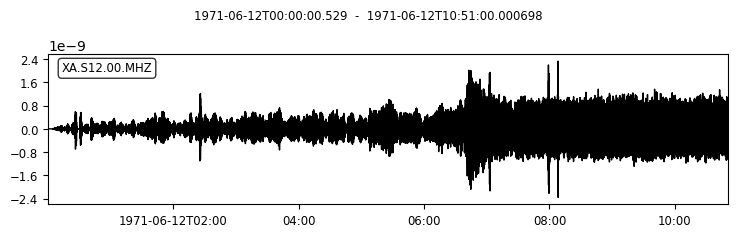

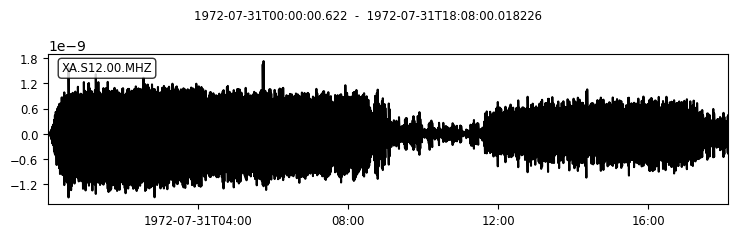

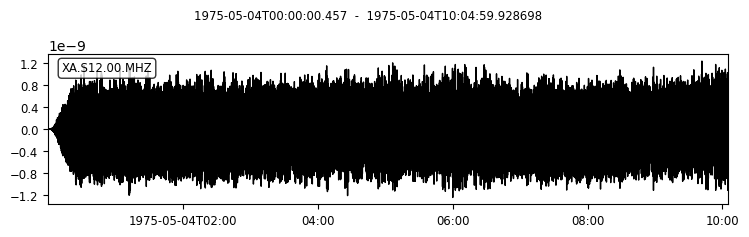

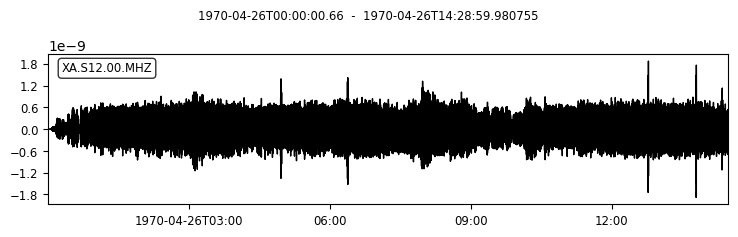

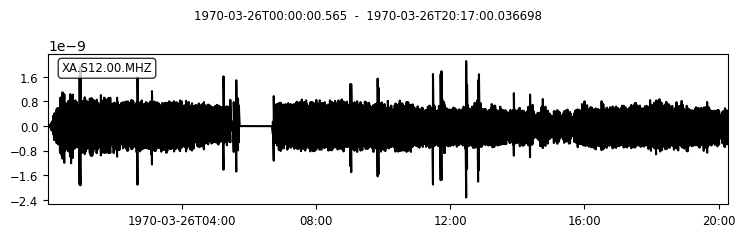

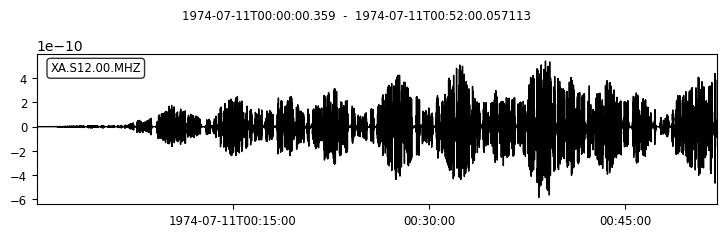

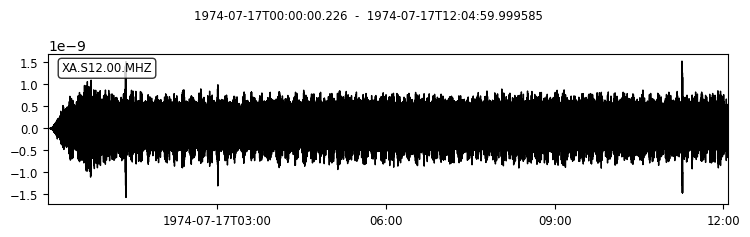

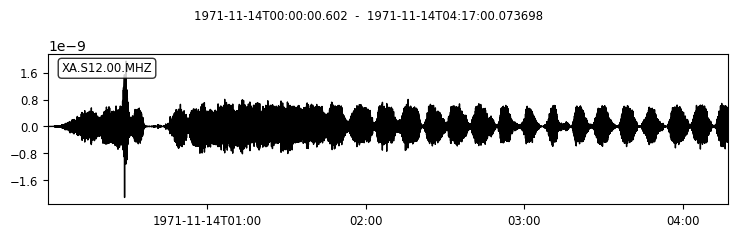

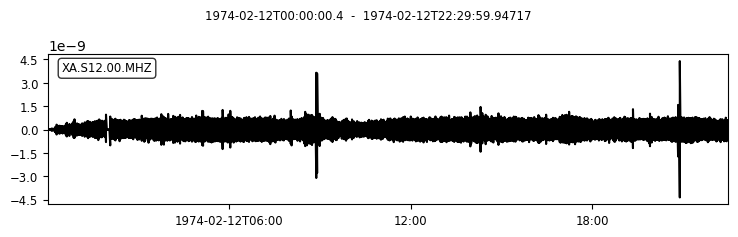

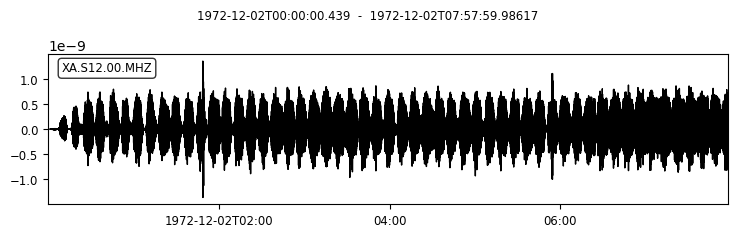

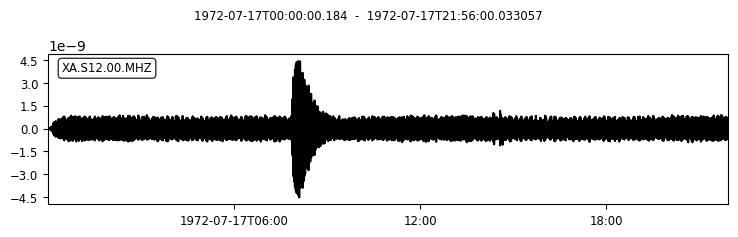

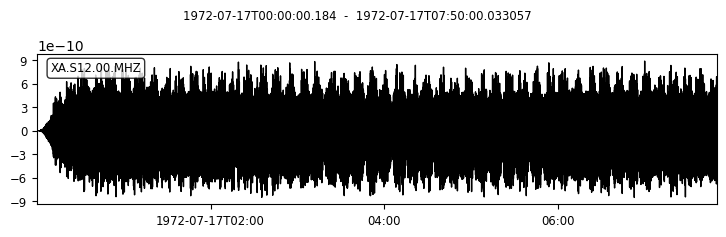

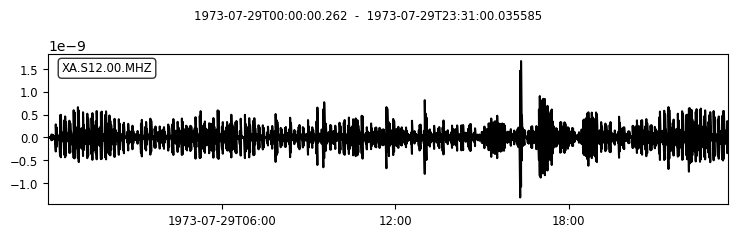

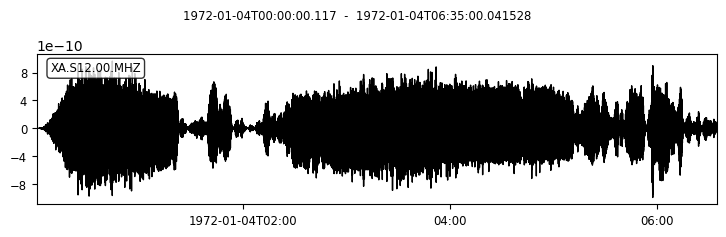

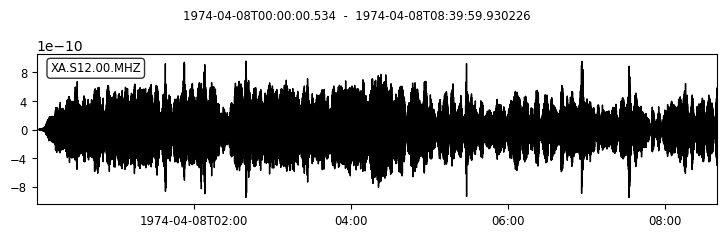

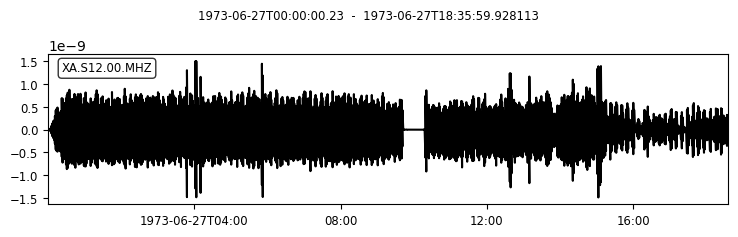

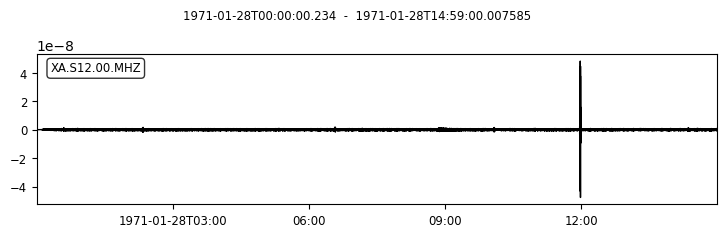

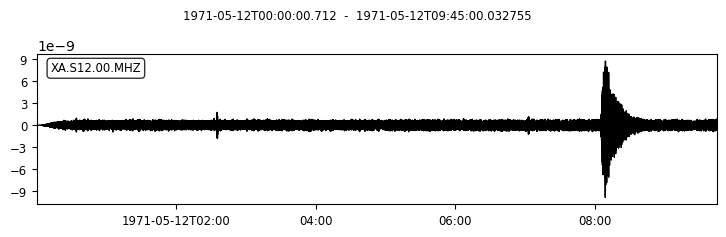

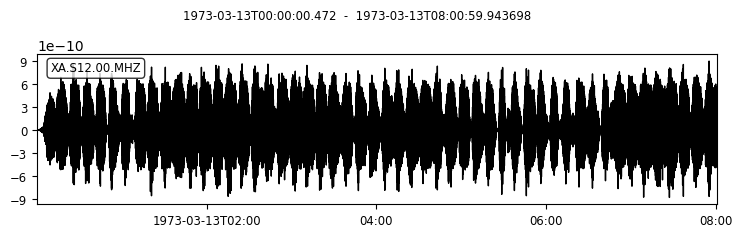

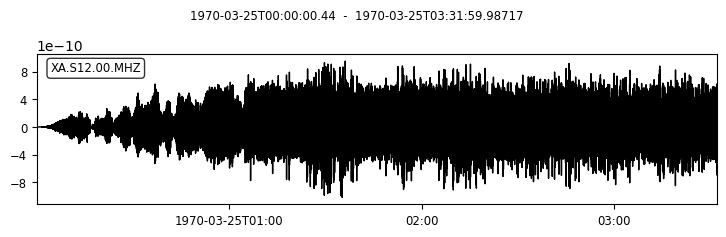

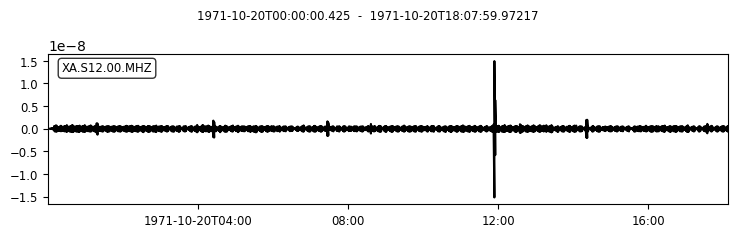

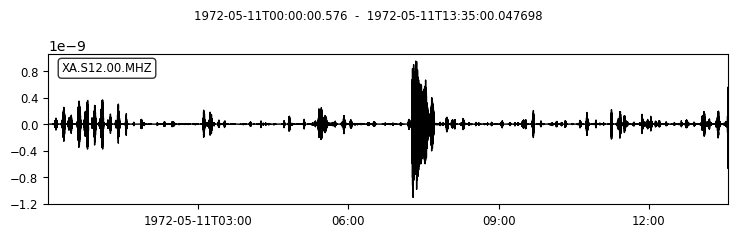

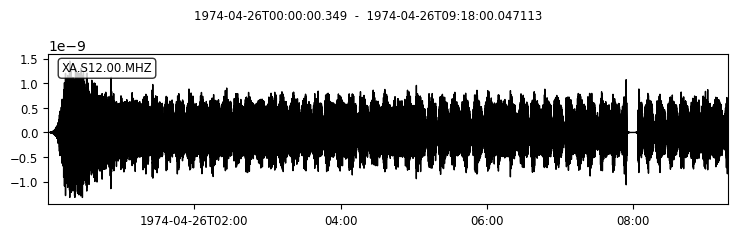

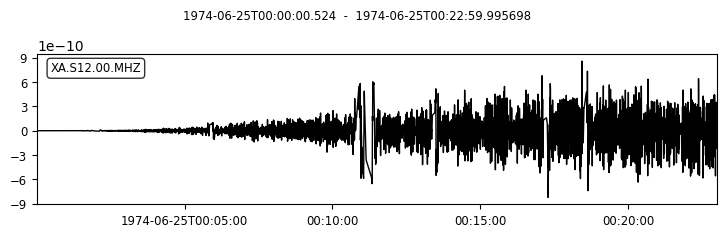

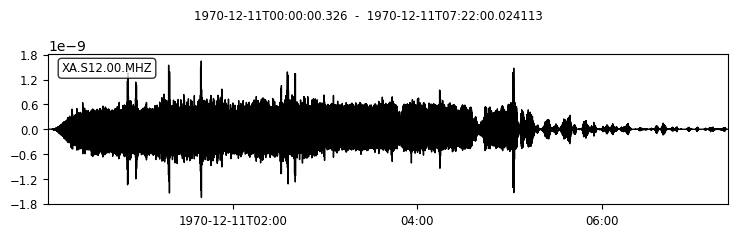

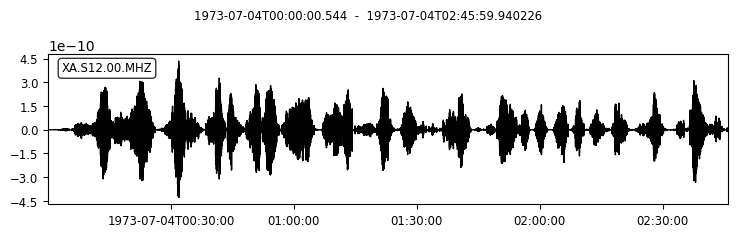

(15924, 12)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 12)                  │              48 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 147 (588.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1311 - val_loss: 0.0276
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0174 - val_loss: 0.0073
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 4/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.2471e-04 - val_loss: 0.0012
Epoch 9/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.5008e-04 - val_loss: 0.0011
Epoch 10/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.5969e-04 - val_loss: 9.7867e-04
Epoch 11/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5475e-04 - val_loss: 9.1655e-04
Epoch 12/100
399/

In [230]:
X_scaled = preprocess_data(input_data=train_data, isTest=False)

# Define the input dimension and encoding dimension
print(X_scaled.shape)
input_dim = X_scaled.shape[1]  # Number of features
encoding_dim = int(input_dim / 2)  # Size of the latent space (can be tuned)

# Build and compile the autoencoder
autoencoder = build_autoencoder(input_dim, encoding_dim)
autoencoder.summary()


# Train the autoencoder
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [349]
[349]


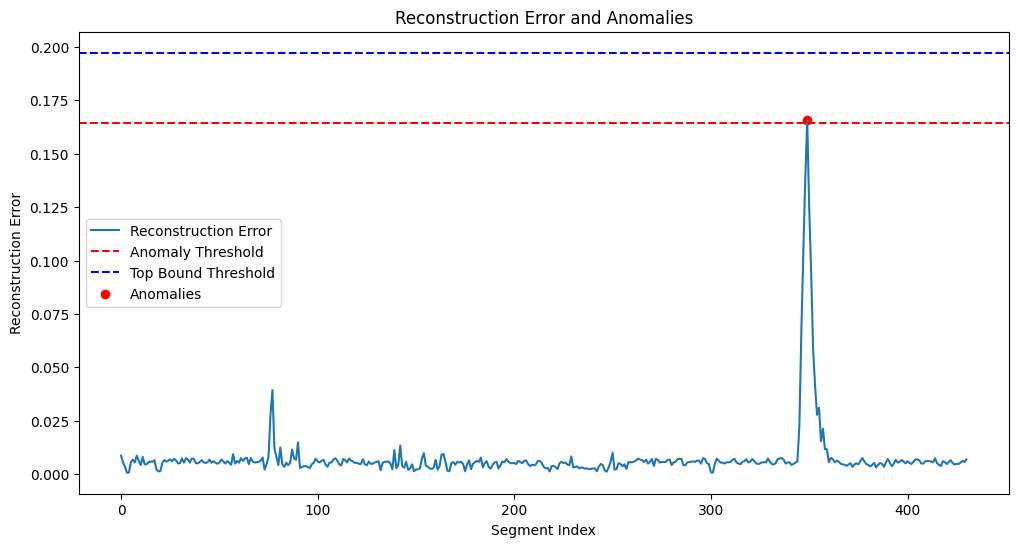

69800.0


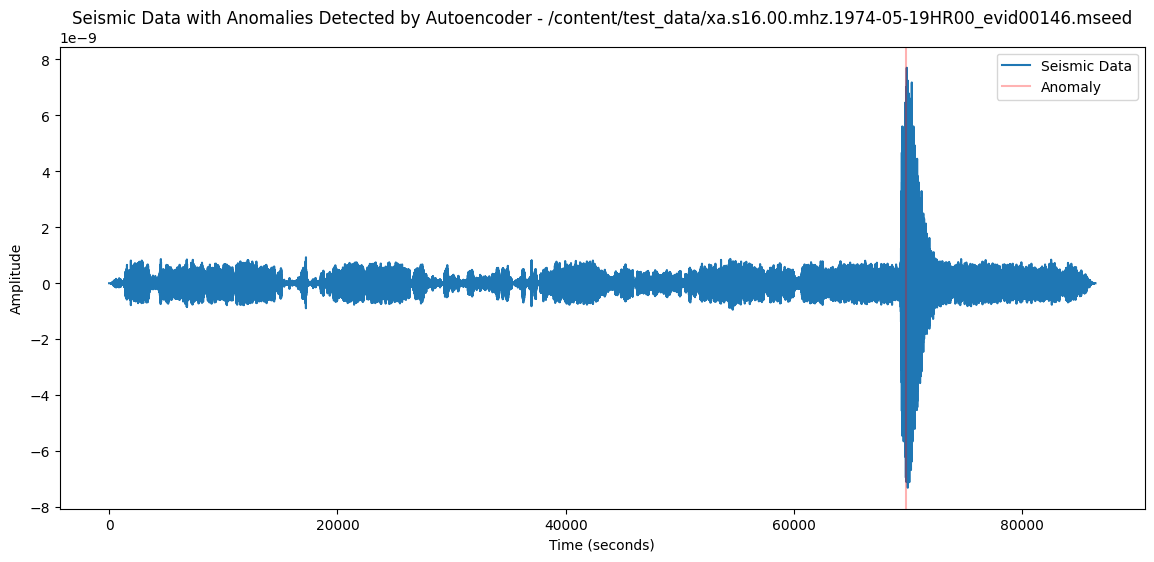

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [81]
[81]


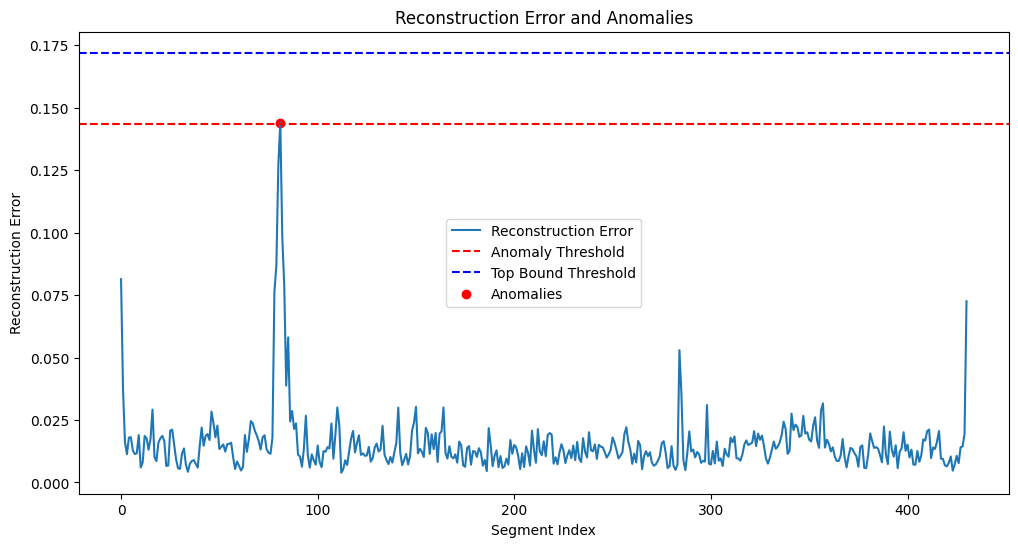

16200.0


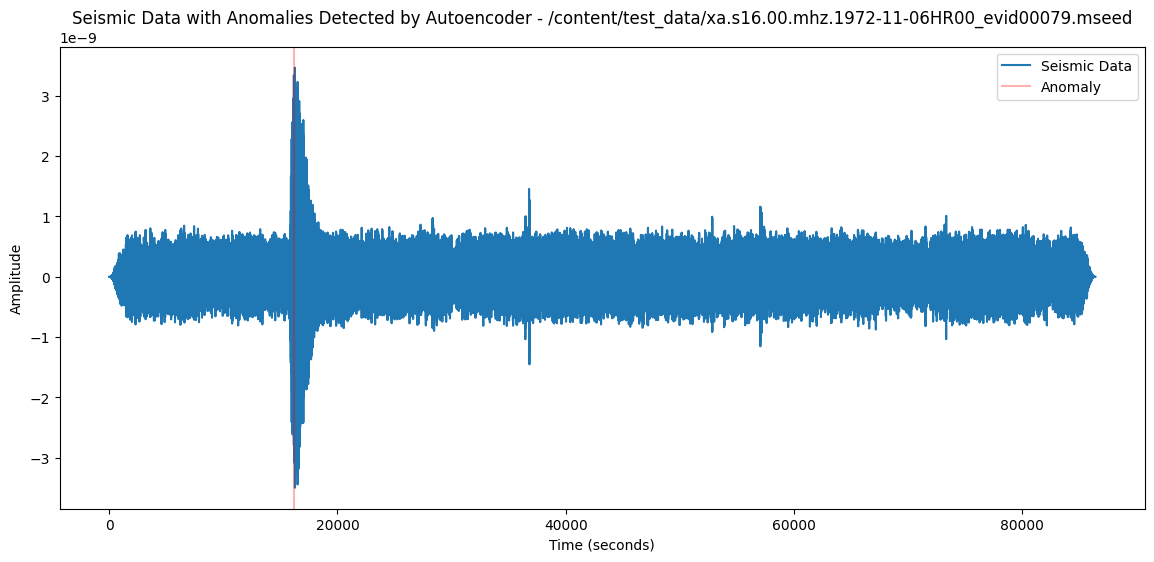

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [167]
[167]


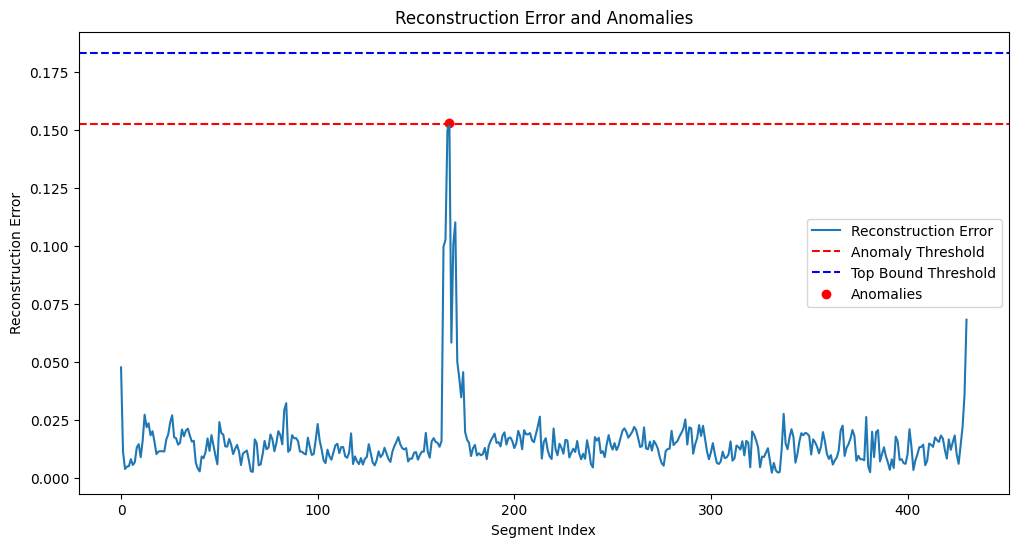

33400.0


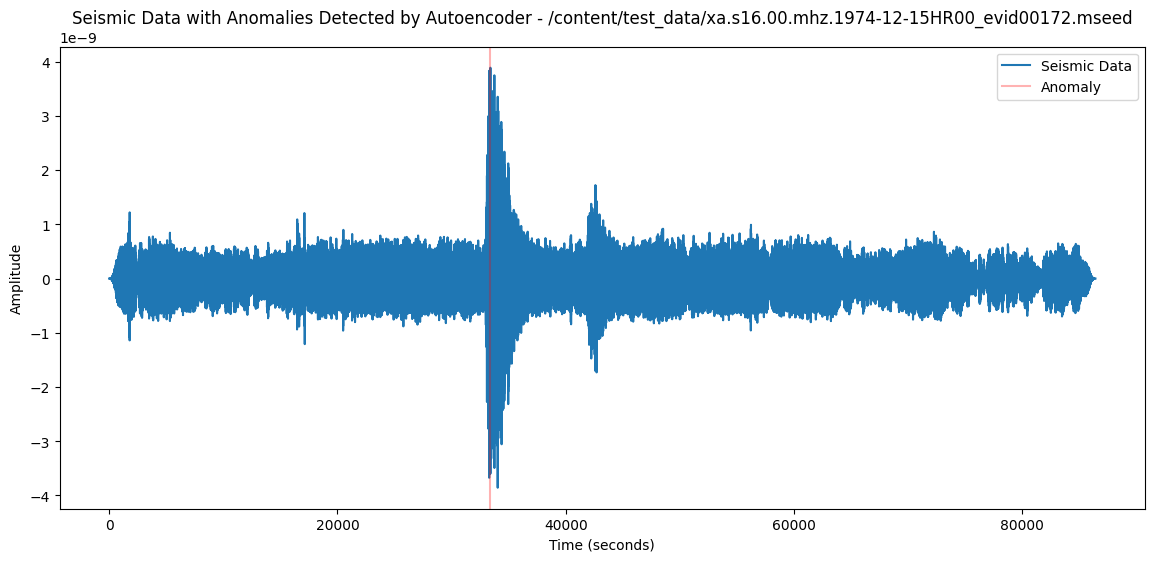

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
reconstruction error:  (16,)
anomalies (16,)
Number of anomalies detected: 1
Anomalous segments: [9]
[9]


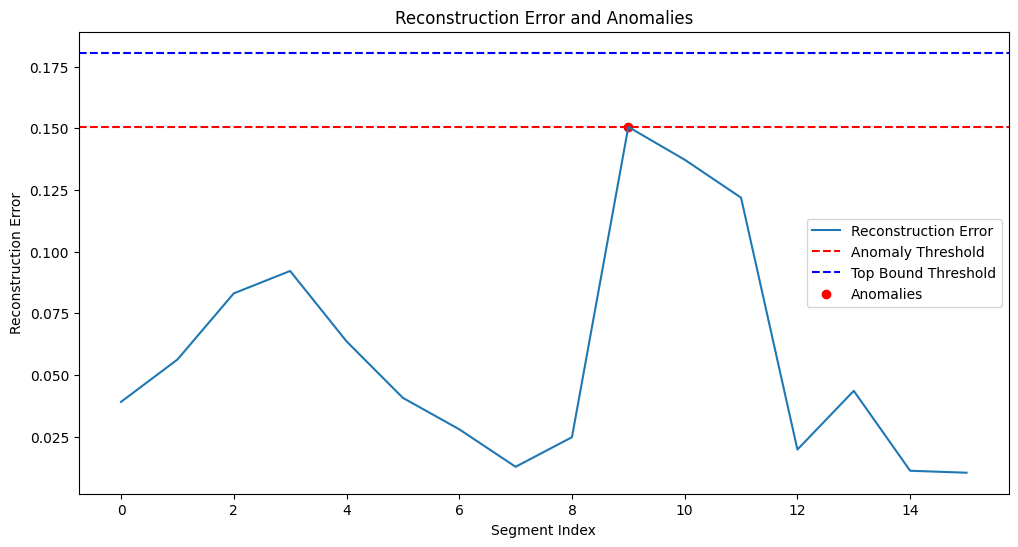

1800.0


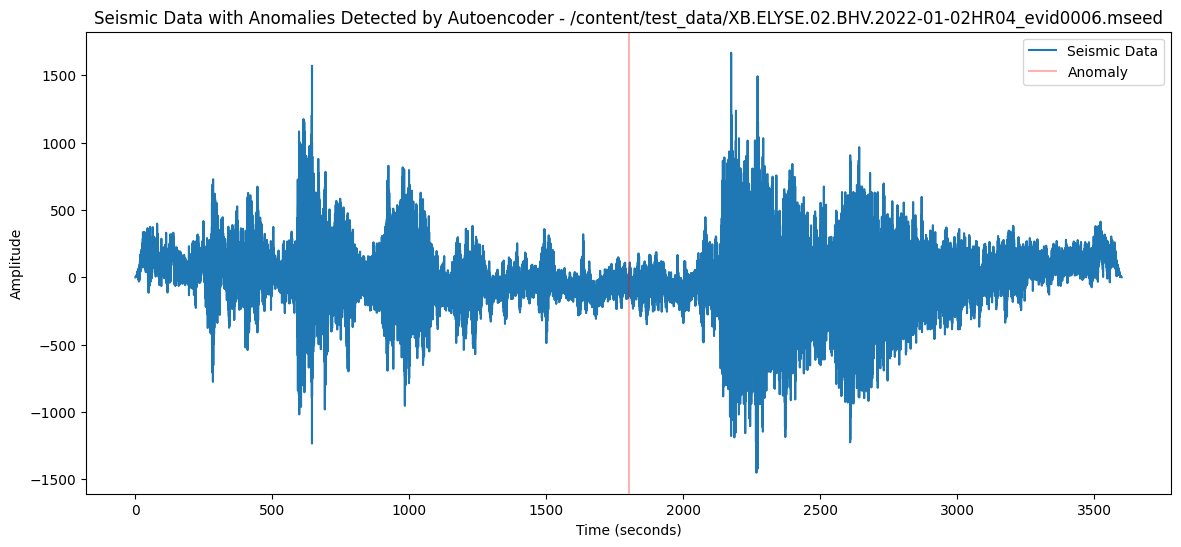

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [387]
[387]


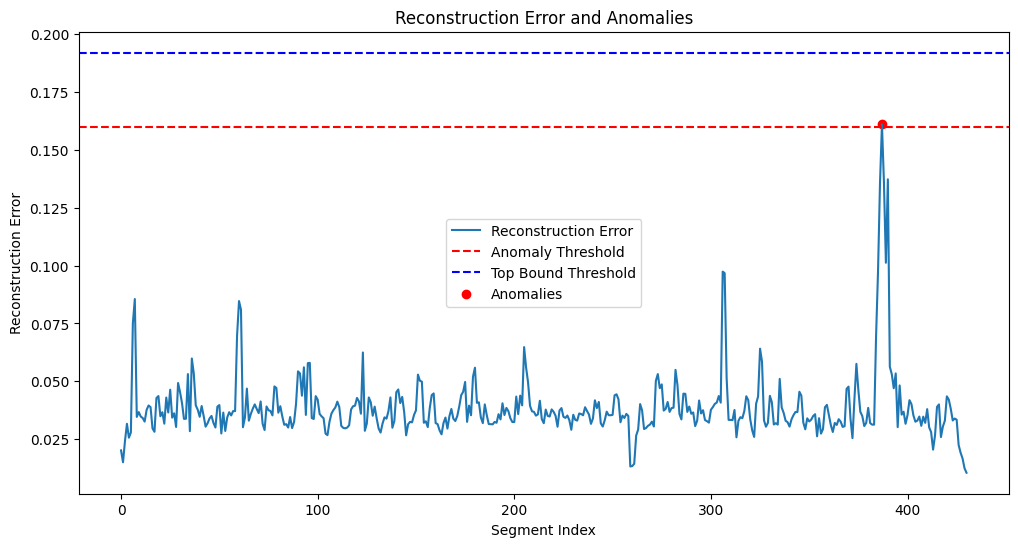

77400.0


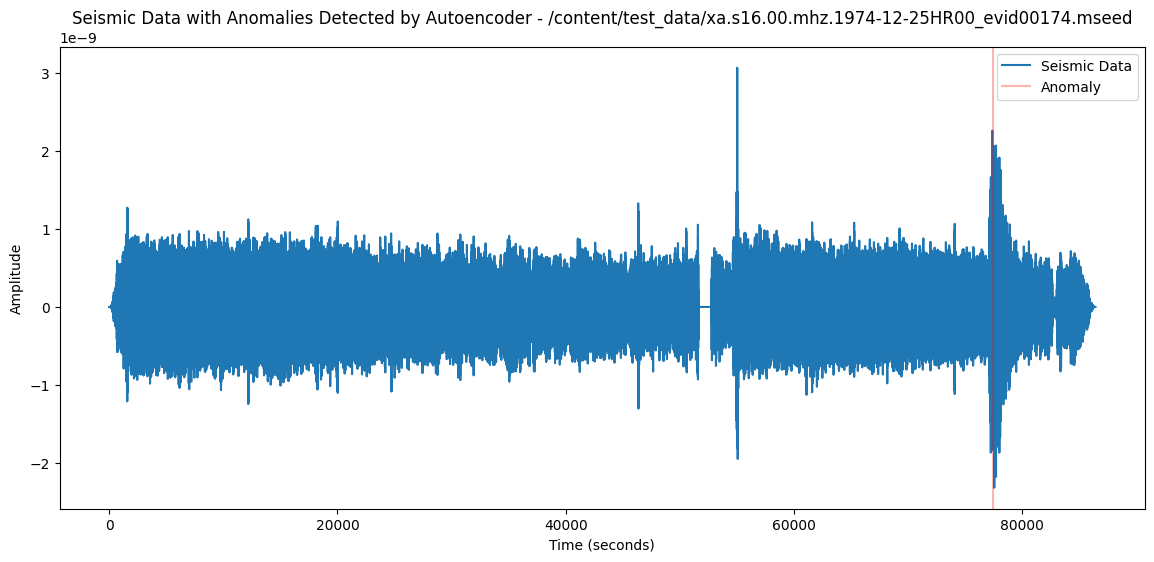

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (430,)
anomalies (430,)
Number of anomalies detected: 1
Anomalous segments: [338]
[338]


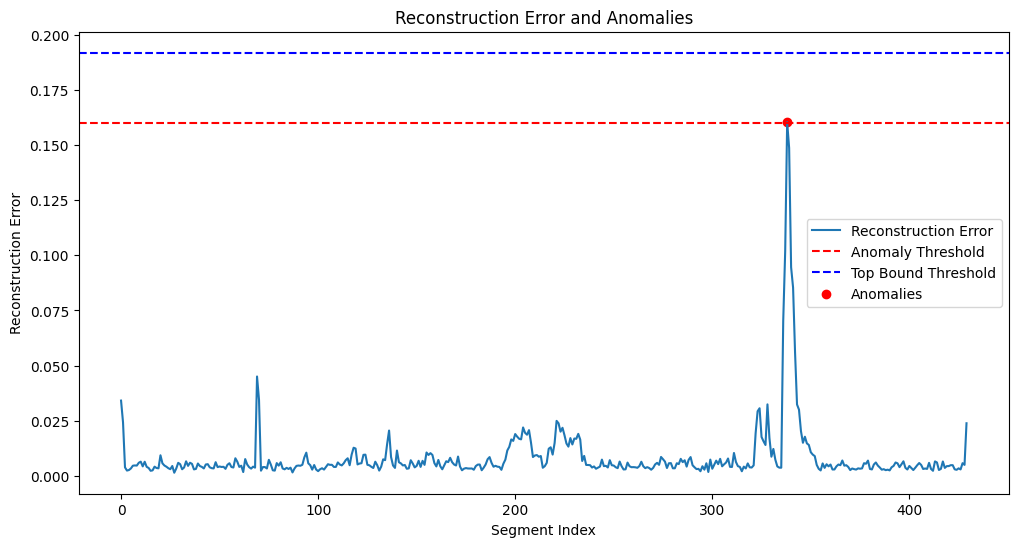

67600.0


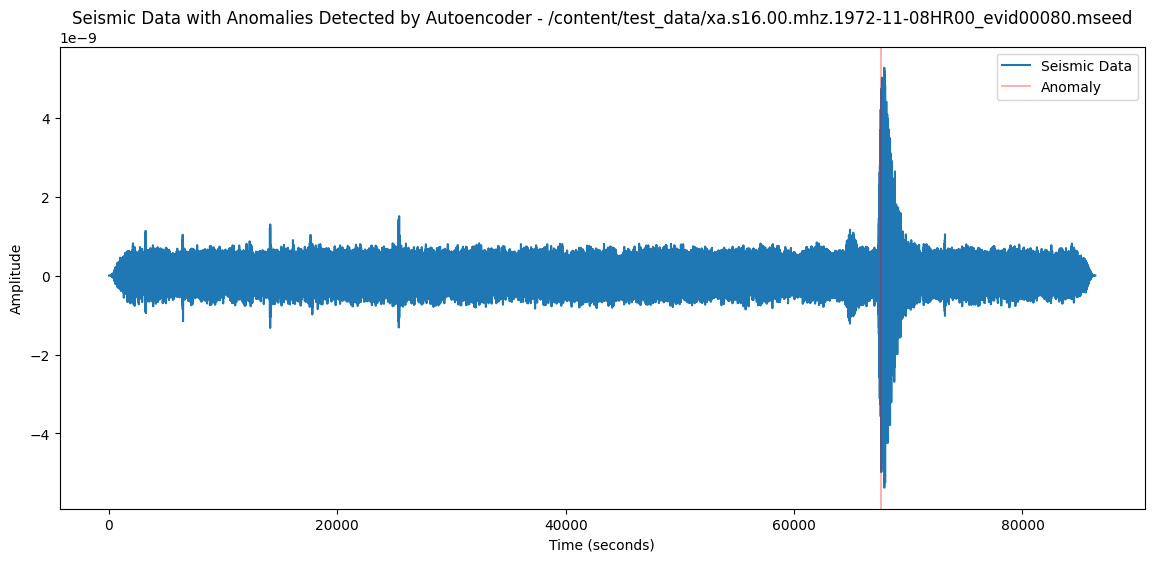

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [179]
[179]


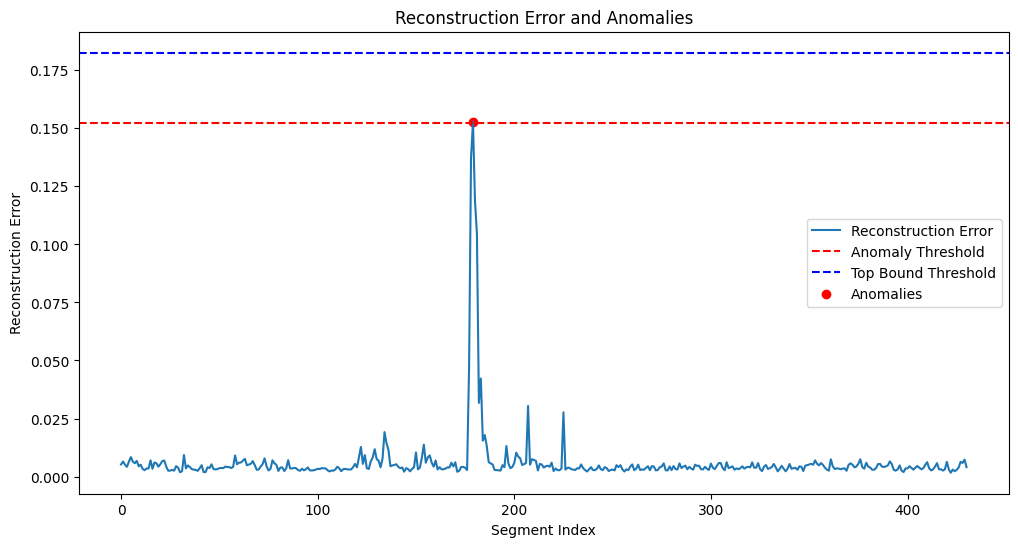

35800.0


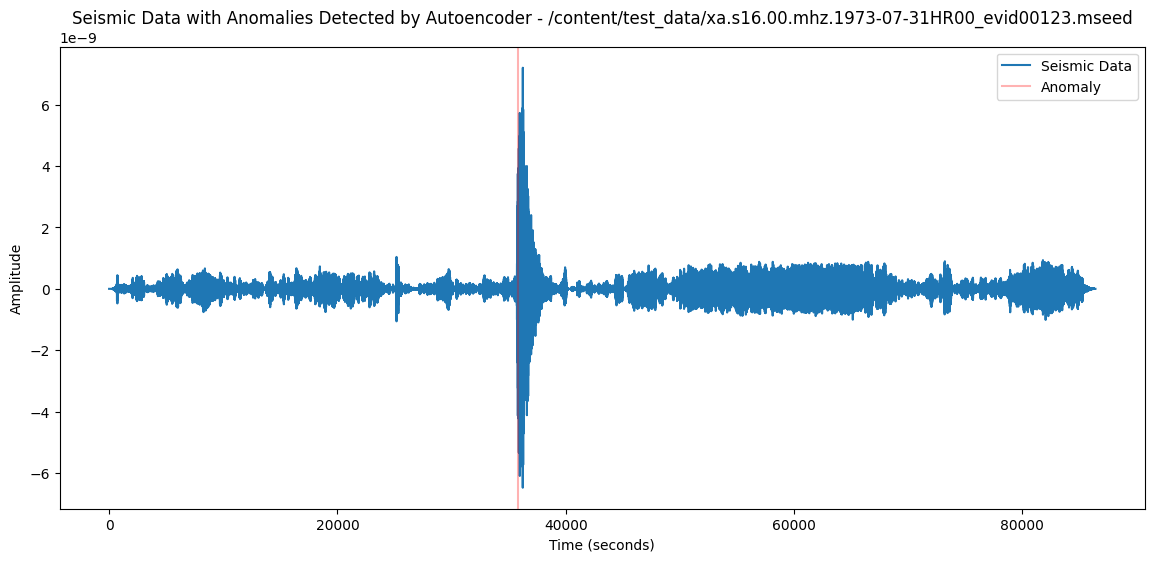

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [317]
[317]


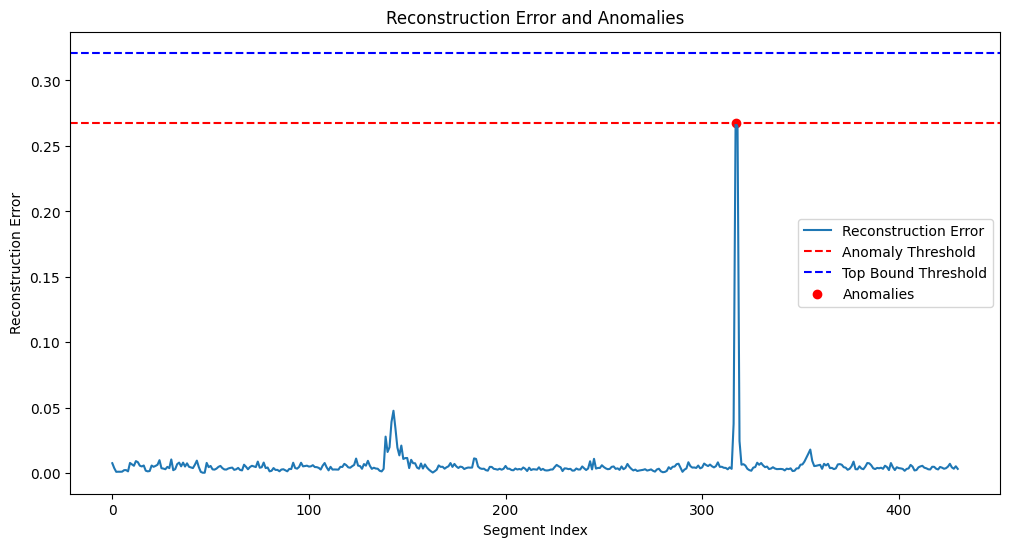

63400.0


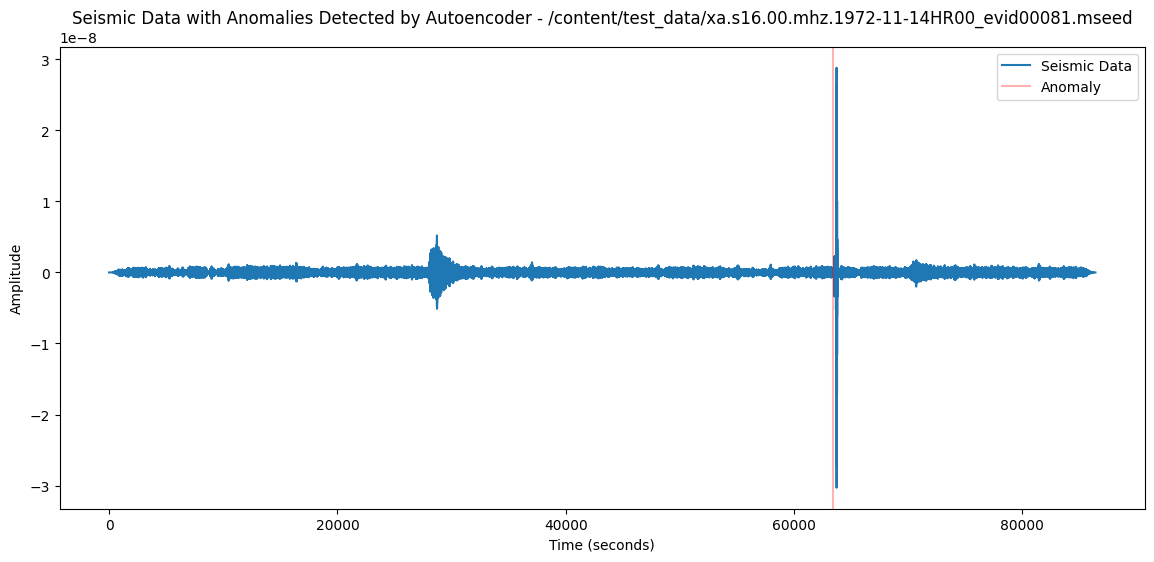

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [252]
[252]


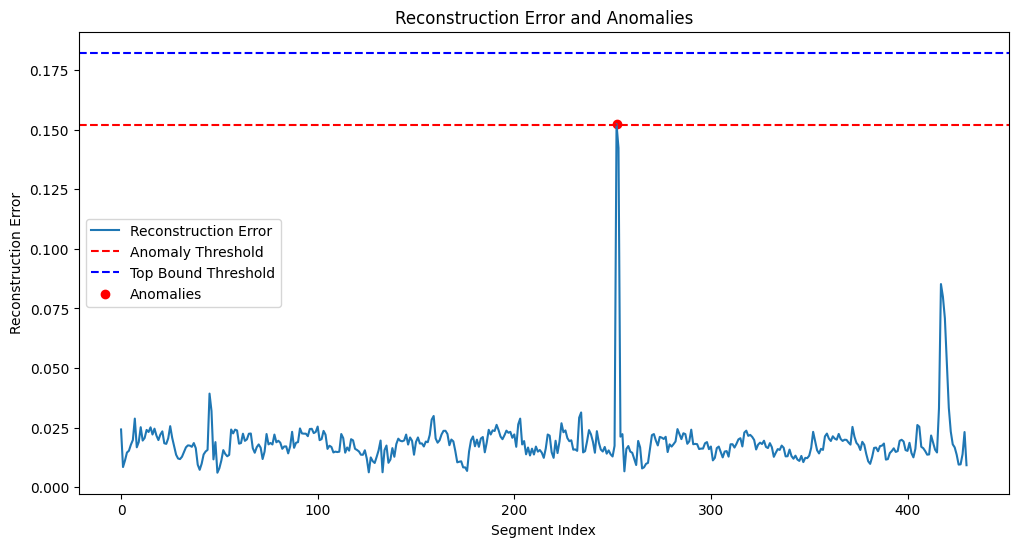

50400.0


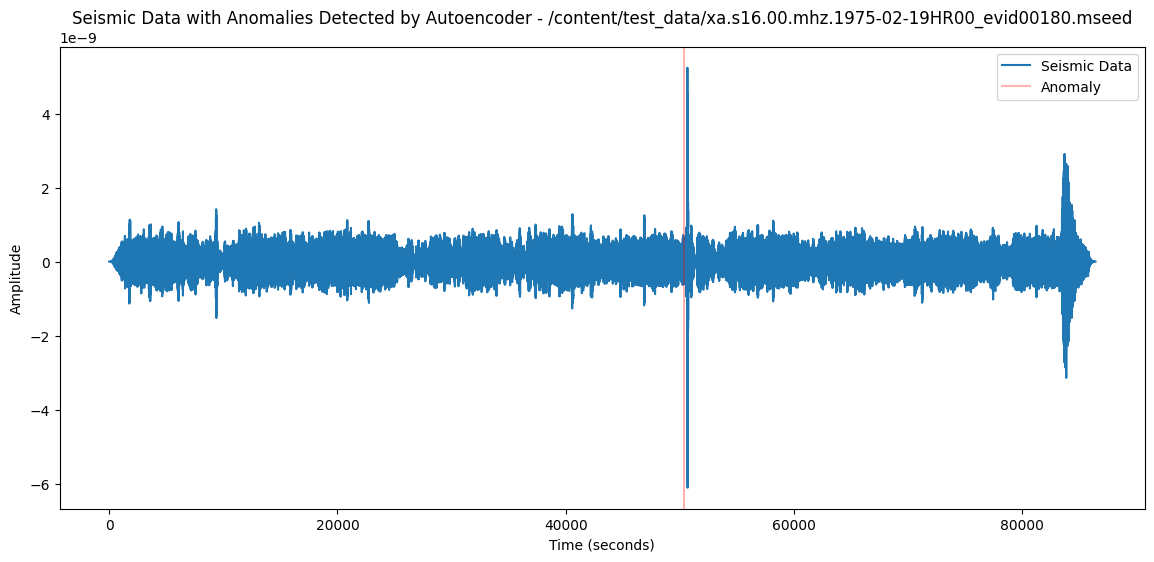

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
reconstruction error:  (16,)
anomalies (16,)
Number of anomalies detected: 1
Anomalous segments: [13]
[13]


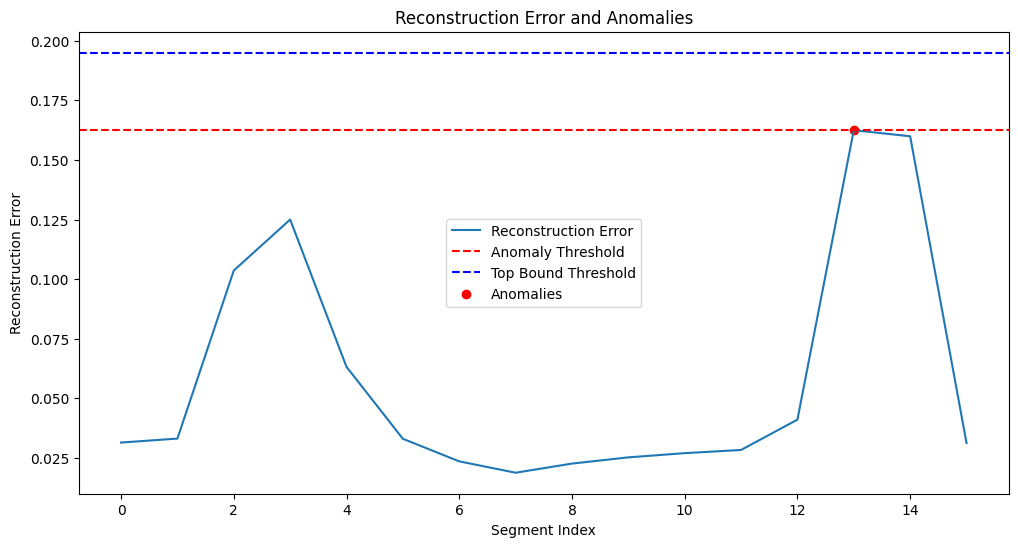

2600.0


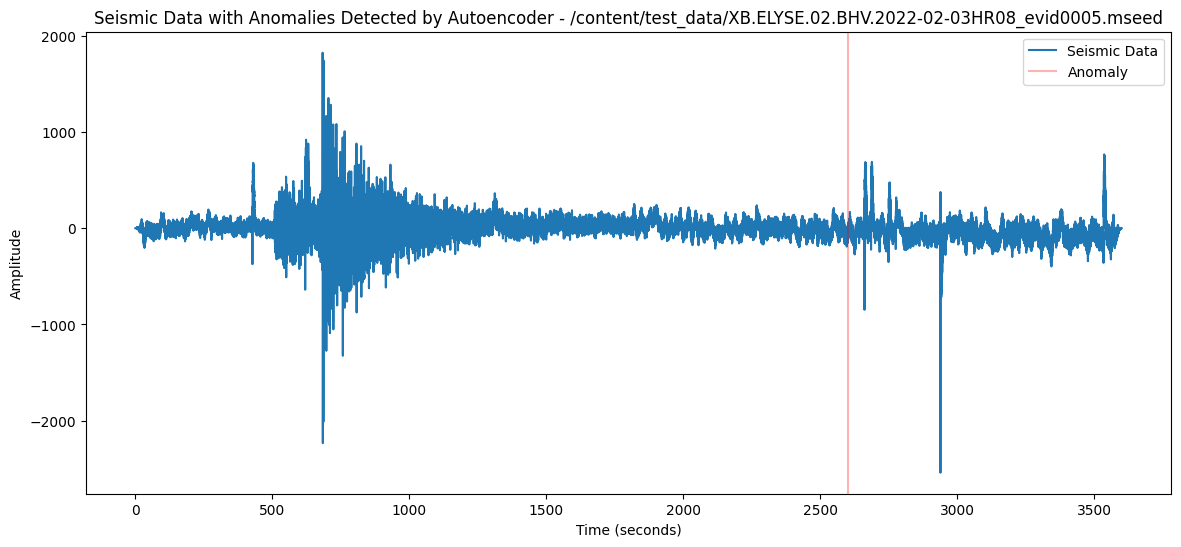

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [261]
[261]


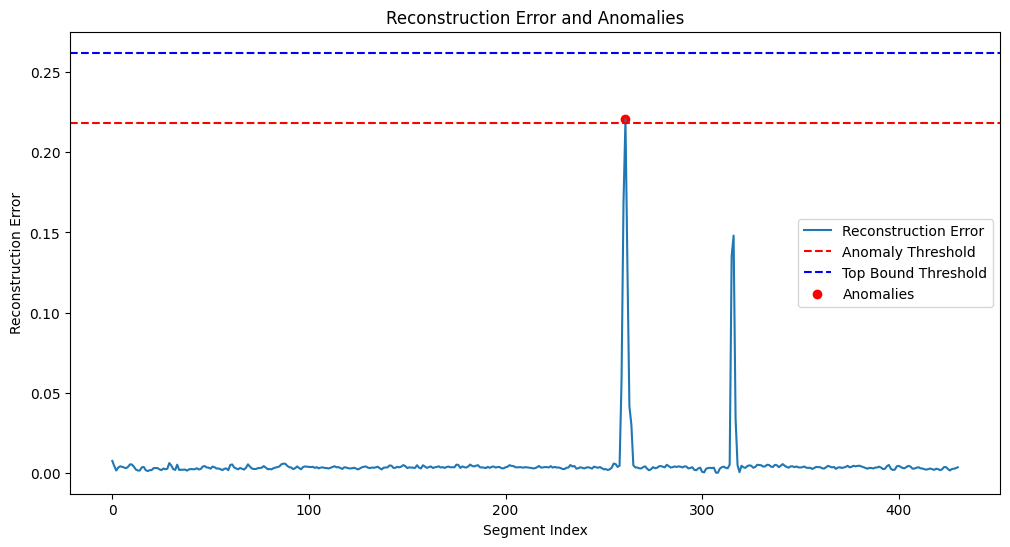

52200.0


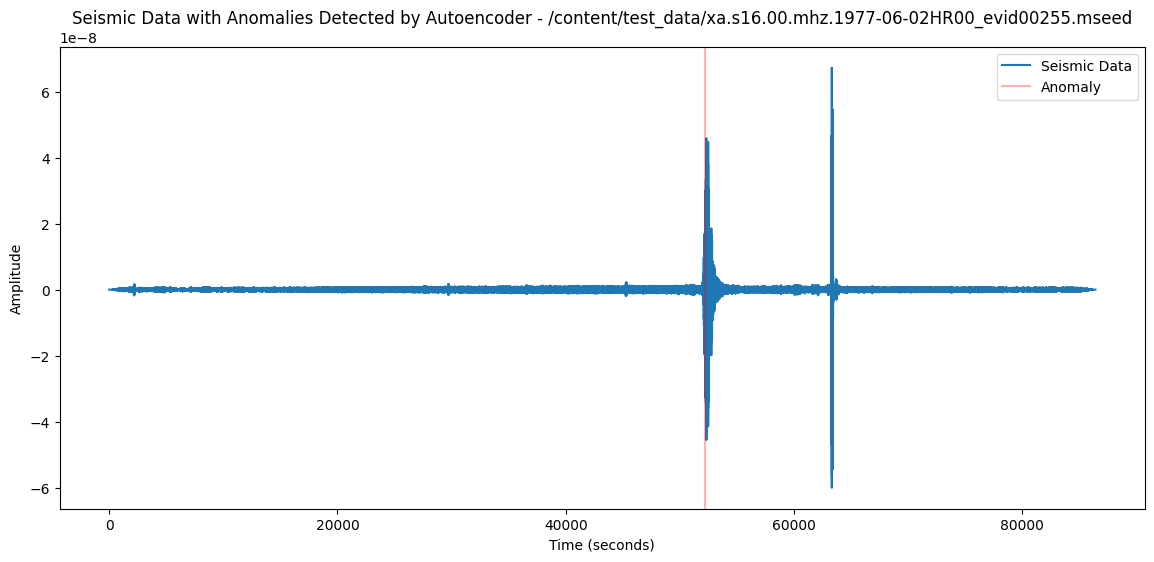

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [307]
[307]


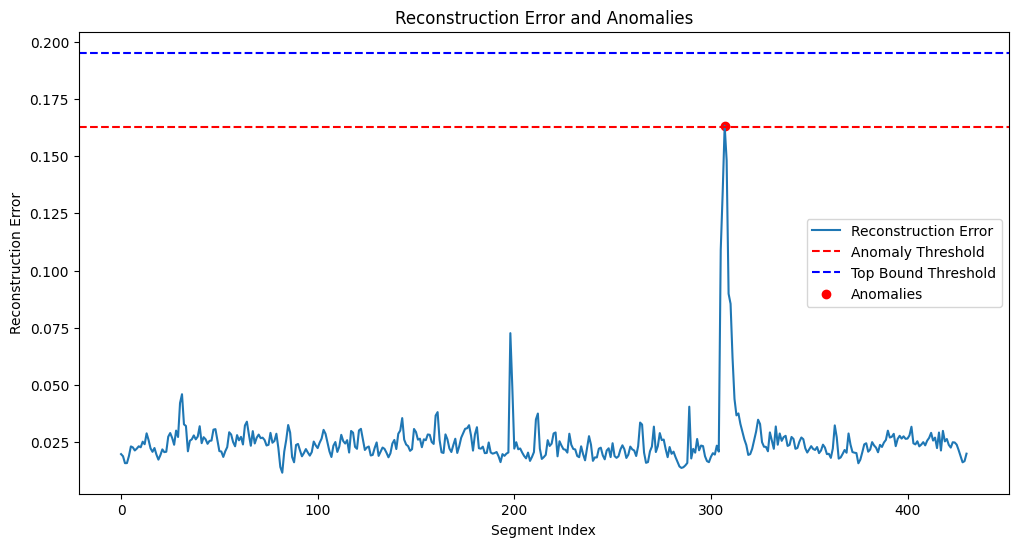

61400.0


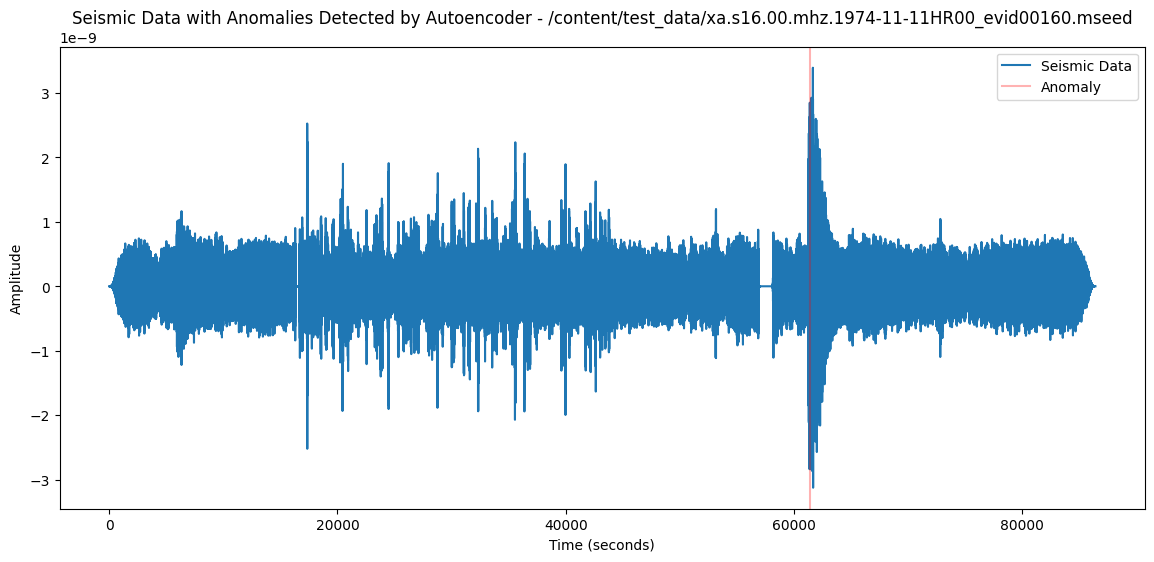

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (431,)
anomalies (431,)
Number of anomalies detected: 1
Anomalous segments: [428]
[428]


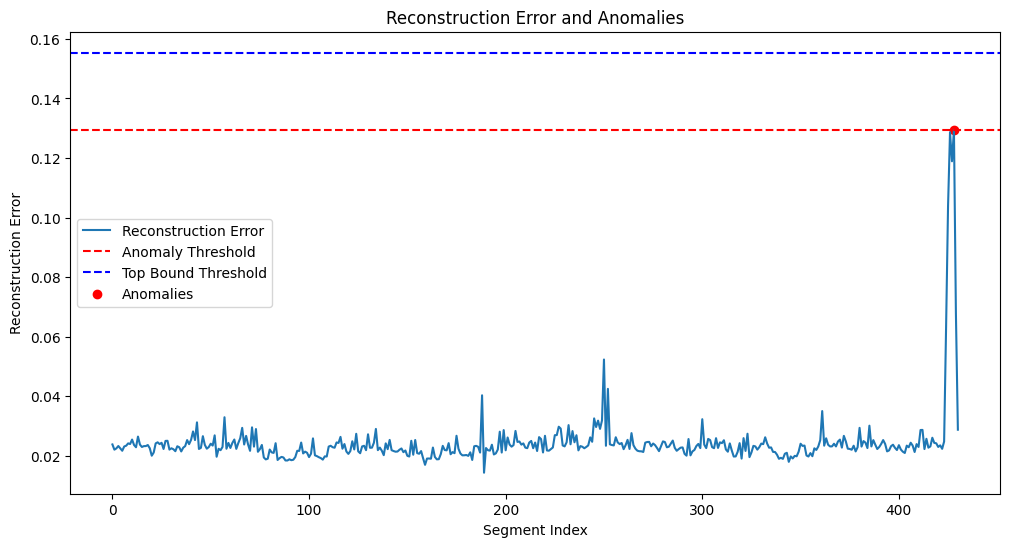

85600.0


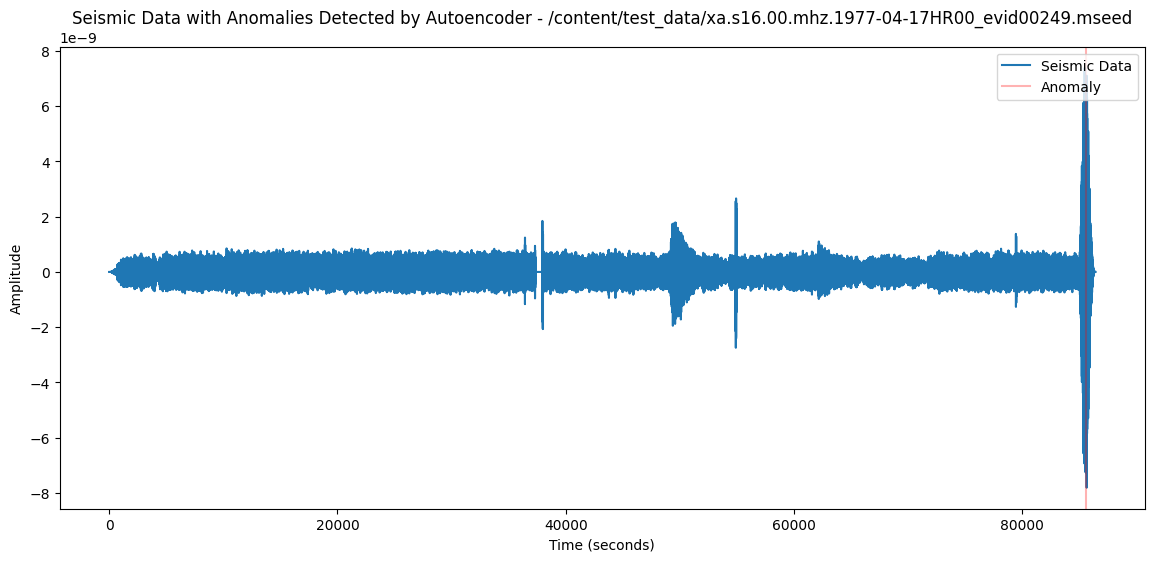

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (429,)
anomalies (429,)
Number of anomalies detected: 1
Anomalous segments: [24]
[24]


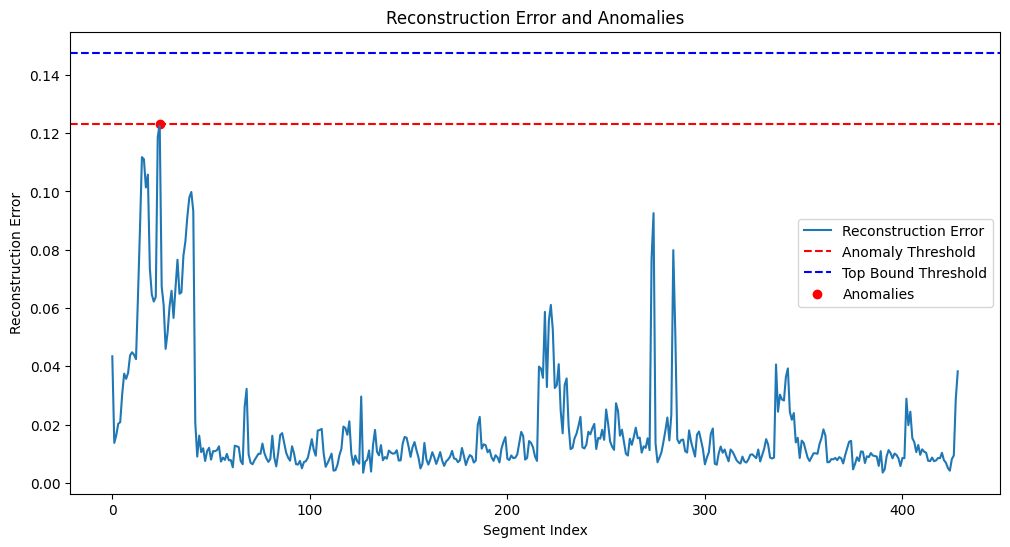

4800.0


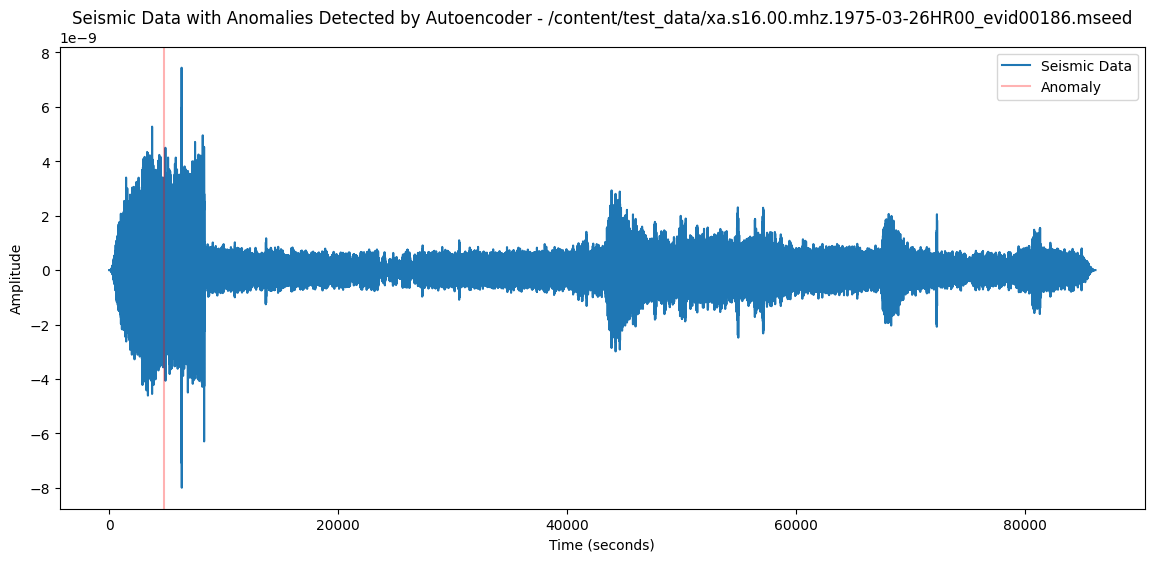

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (413,)
anomalies (413,)
Number of anomalies detected: 1
Anomalous segments: [238]
[238]


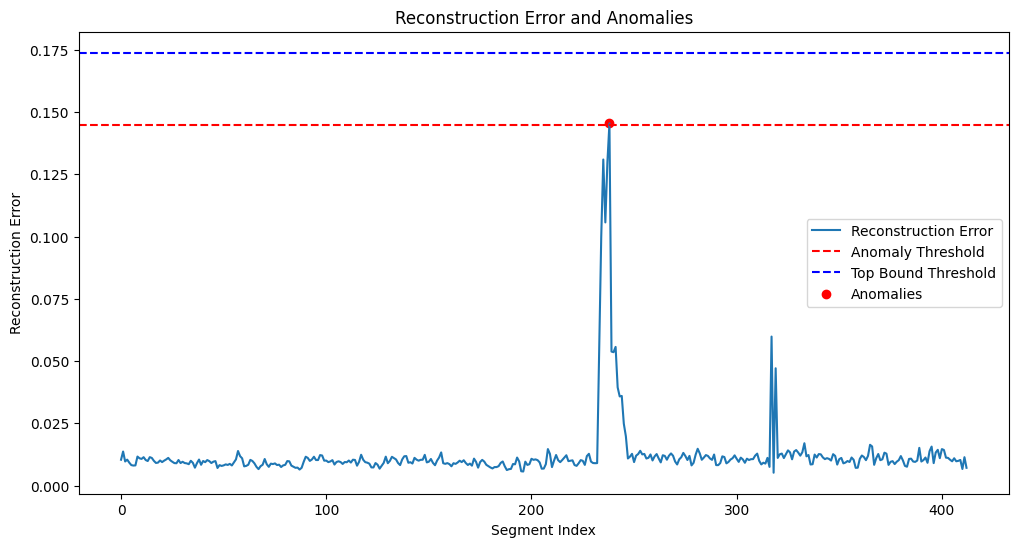

47600.0


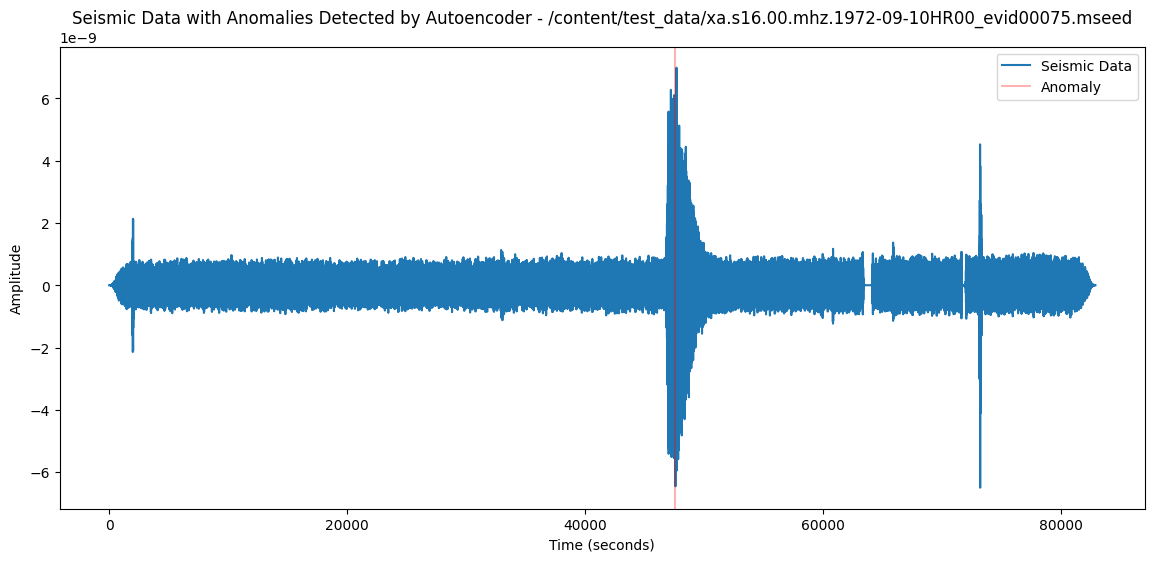

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
reconstruction error:  (390,)
anomalies (390,)
Number of anomalies detected: 1
Anomalous segments: [246]
[246]


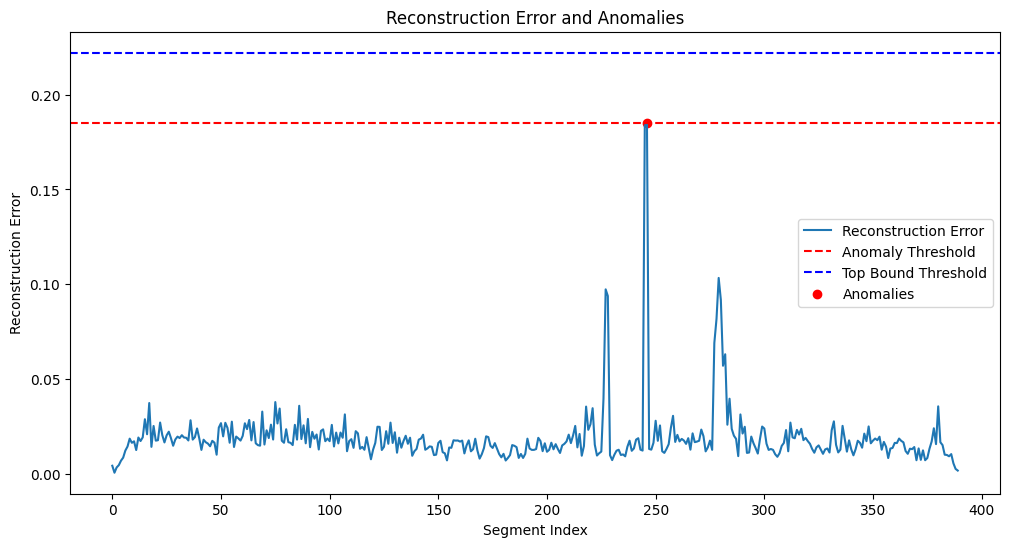

49200.0


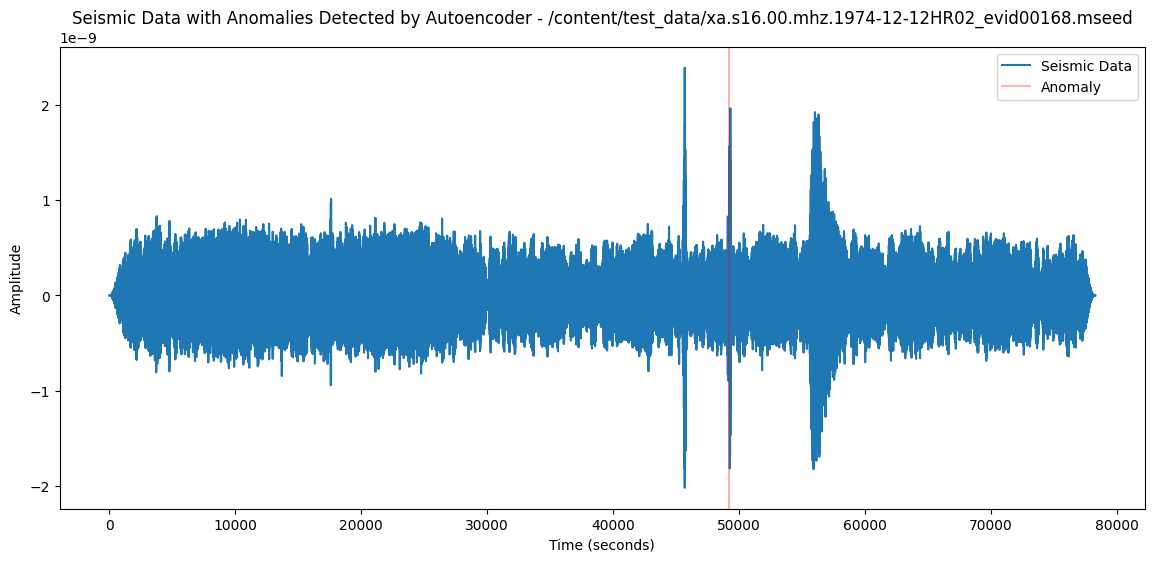

In [231]:
# Start the test run

for file in test_data:
  X_test = preprocess_data(input_data=[file], isTest=True)

  reconstructed_data = autoencoder.predict(X_test)

  reconstruction_error = np.mean(np.square(X_test - reconstructed_data), axis=1)

  # set a threshold based on error percentile
  threshold = np.percentile(reconstruction_error, 99.99)

  print("reconstruction error: ", reconstruction_error.shape)

  anomalies = np.empty_like(reconstruction_error, dtype=bool)
  # set anomalied based on threshold and upper bound
  for i in range(len(reconstruction_error)):
    if reconstruction_error[i] > threshold and reconstruction_error[i] < (threshold * 1.2):
      anomalies[i] = True
    else:
      anomalies[i] = False
  print("anomalies", anomalies.shape)
  print(f"Number of anomalies detected: {np.sum(anomalies)}")

  anomalous_indices = np.where(anomalies)[0]
  print("Anomalous segments:", anomalous_indices)

  # Find clusters of anomalous segments, we are interested in errors
  # that are clustered rather than sparse outliers
  def find_clusters(arr, threshold=10):
    clusters = [arr[0]]  # Start with the first element

    for i in range(1, len(arr)):
        # If the difference between consecutive elements exceeds the threshold,
        # start a new cluster and add the first element of the new cluster
        if arr[i] - arr[i - 1] > threshold:
            clusters.append(arr[i])

    return clusters

  if len(anomalous_indices) == 0:
    continue
  relevant_indices = find_clusters(anomalous_indices, 5)
  print(relevant_indices)



  # Plot reconstruction error and highlight anomalies
  plt.figure(figsize=(12, 6))
  plt.plot(reconstruction_error, label="Reconstruction Error")
  plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")
  plt.axhline(y=threshold * 1.2, color='b', linestyle='--', label="Top Bound Threshold")
  plt.scatter(relevant_indices, reconstruction_error[relevant_indices], color='r', label="Anomalies")
  plt.title("Reconstruction Error and Anomalies")
  plt.xlabel("Segment Index")
  plt.ylabel("Reconstruction Error")
  plt.legend()
  plt.show()

  # Generate a time vector for the original seismic data
  st = read(file)
  tr = st[0]
  sampling_rate = tr.stats.sampling_rate
  n_samples = len(tr)
  time_vector = np.arange(0, n_samples) / sampling_rate

  # Calculate the start times of each segment
  segment_duration = 400  # Duration of each segment in seconds
  segment_step = segment_duration * (1 - 0.5)  # Step size between segments in seconds

  # Start times of each segment
  segment_times = np.arange(0, len(relevant_indices) * segment_step, segment_step)

  # 3. Plot the original data
  plt.figure(figsize=(14, 6))
  plt.plot(time_vector, tr.data, label='Seismic Data')

  # 4. Mark anomalies in the plot
  for idx in relevant_indices:
      # Calculate the start and end times of the anomalous segment
      anomaly_start_time = idx * segment_step
      anomaly_end_time = anomaly_start_time + segment_duration

      # Highlight the anomalous region on the plot (shaded region)
      plt.axvline(anomaly_start_time, color='red', alpha=0.3, label='Anomaly')
      print(anomaly_start_time)

  # 5. Labeling the plot
  plt.title(f'Seismic Data with Anomalies Detected by Autoencoder - {file}')
  plt.xlabel('Time (seconds)')
  plt.ylabel('Amplitude')
  plt.legend(loc='upper right')
  plt.show()


